In [ ]:
from config import settings
from hannover_pylon.data import datamodules as dm
from pathlib import Path
from hannover_pylon.modelling.transformation import FromBuffer , CutPSD
import matplotlib.pyplot as plt
from torch import nn 
%load_ext autoreload
%autoreload 2

/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/torchdata/datapipes/__init__.py:18: UserWarning: 
################################################################################
WARNING!
The 'datapipes', 'dataloader2' modules are deprecated and will be removed in a
future torchdata release! Please see https://github.com/pytorch/data/issues/1196
to learn more and leave feedback.
################################################################################

  deprecation_warning()


In [19]:
import numpy as np

freq_axis = np.linspace(0, 825.5, 8197)
db_path = Path(settings.path.processed,'Welch(n_fft=16392, fs=1651, max_freq=825.5).db')
columns= ['psd']
transform_func = [nn.Sequential(FromBuffer(),CutPSD(freq_axis=freq_axis,freq_range=(0,150)))]
query_key = f'''
    SELECT id FROM data
    WHERE sensor = "accel"
    AND date BETWEEN "{settings.state.healthy_train.start}" AND "{settings.state.healthy_train.end}"
    AND corrupted = 0
'''
data_loader = dm.PSDDataModule(db_path= db_path,columns=columns,transform_func=transform_func, query_key=query_key, batch_size=32, return_dict=False, cached=False)


In [20]:
import pandas as pd 
import sqlite3
conn = sqlite3.connect(db_path)

# Read the 'meteo_data' table into a DataFrame
data_meteo = pd.read_sql('SELECT * FROM meteo_data', conn)
df_plot_meteo = data_meteo.pivot_table(index='date', columns='channel_name', values='value')
df_plot_meteo.index = pd.to_datetime(df_plot_meteo.index)
# Close the database connection
conn.close()

In [21]:
# let's read all psds 
conn = sqlite3.connect(db_path)
data_psd = pd.read_sql('SELECT * FROM data', conn)


In [22]:
data_psd['psd'] = data_psd['psd'].apply(lambda x: np.frombuffer(x, dtype=np.float32))

In [23]:
data_psd['date'] = pd.to_datetime(data_psd['date'])
#filter the training data as set in the config
data_psd = data_psd[(data_psd['date'] >= settings.state.healthy_train.start) & (data_psd['date'] <= settings.state.healthy_train.end)]
data_psd = data_psd[data_psd['sensor'] == 'accel']
# plot all psds of level 1 


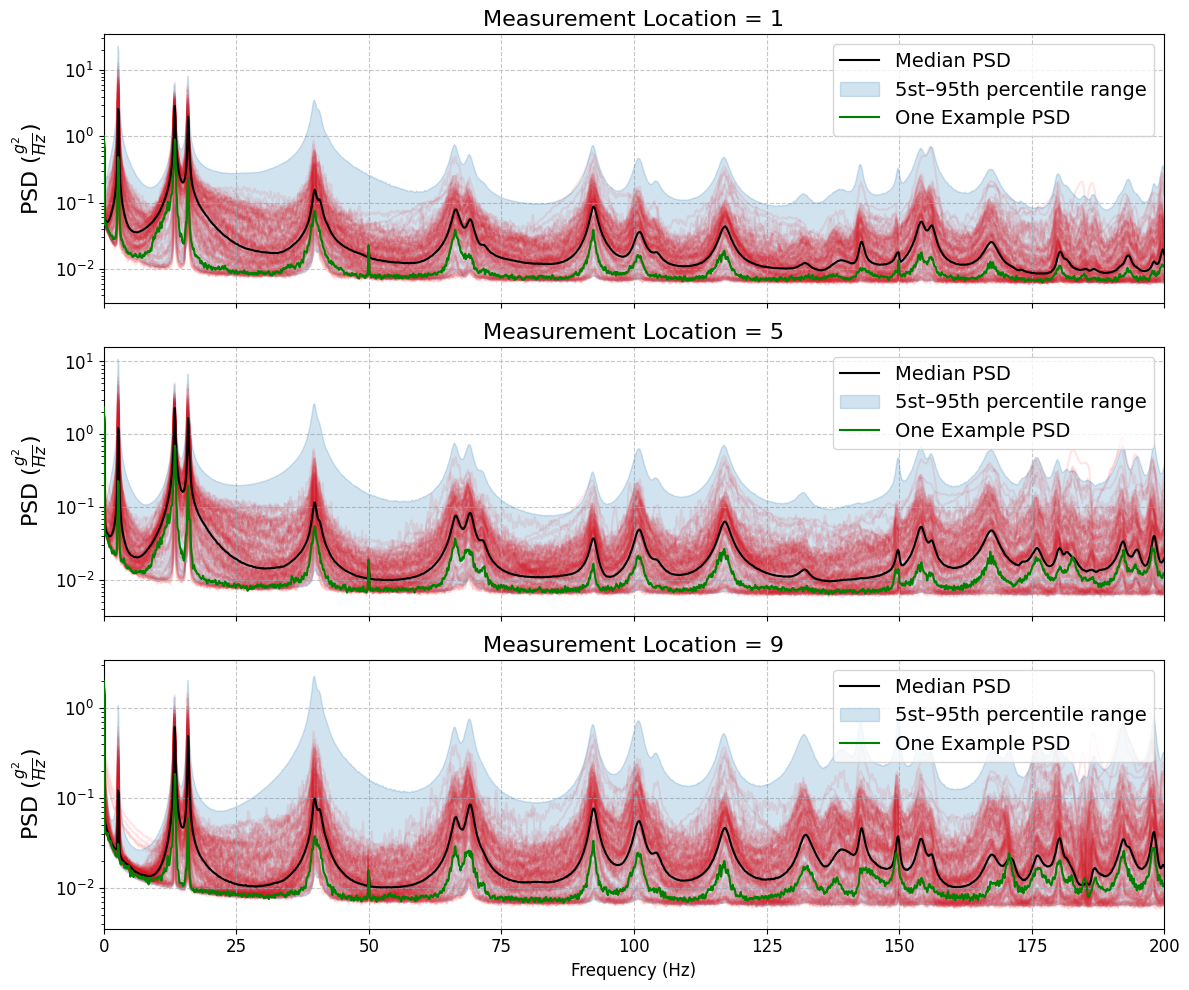

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Three subplots (one for each level) in a single figure
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True, sharey=False)
levels_of_interest = [1, 5, 9]

for i, level in enumerate(levels_of_interest):
    ax = axes[i]
    
    # Filter data for the current level
    data_psd_plot = data_psd[(data_psd['level'] == level) & (data_psd['direction'] == 'y')]
    
    # Stack PSD arrays into shape (num_samples, freq_bins)
    psds_all = np.stack(data_psd_plot['psd'].values)
    psds_all = np.exp(psds_all)  # undo the log transformation
    # Calculate some statistics across the PSDs for this level
    median_psd = np.median(psds_all, axis=0)
    p99 = np.quantile(psds_all, 0.95, axis=0)
    p01 = np.quantile(psds_all, 0.05, axis=0)
    
    # Plot the median PSD
    ax.plot(
        freq_axis,
        median_psd,
        label='Median PSD',
        color='black',
        zorder=3
    )
    
    # Fill region between 1st and 99th quantile
    ax.fill_between(
        freq_axis,
        p01,
        p99,
        color='tab:blue',
        alpha=0.2,
        label='5st–95th percentile range',
        zorder=2
    )
    
    # Overlay a subset of individual PSDs to show variability
    # e.g., first 100 (or 600) curves for clarity
    ax.plot(
        freq_axis,
        psds_all[:100].T,
        color='red',
        alpha=0.1,
        zorder=1,
        label='_nolegend_'  # hide these from the legend
    )
    ax.set_yscale('log')
    ax.set_xlim(0, 200)
    ax.set_title(f'Measurement Location = {level}', fontsize=16)
    ax.grid(True, linestyle='--', alpha=0.7)
    # plot one example with alpha = 1 
    ax.plot(freq_axis, psds_all[180], color='green', alpha=1, label='One Example PSD', zorder=4)
    # add ylabel  that is psd unit of acceleration which is g^2/Hz using latex formatting
    ax.set_ylabel(r'PSD ($\frac{g^2}{Hz}$)', fontsize=16)
    ax.legend(loc='upper right', fontsize=14)

axes[-1].set_xlabel('Frequency (Hz)', fontsize=12)
# increase the fontsize of the xticks and yticks
for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
plt.show()


# Dense AE 

In [25]:
import torch
import torch.nn as nn

class NormLayer(nn.Module):
    def __init__(self, max_val, min_val, denormalize=False):
        super(NormLayer, self).__init__()
        self.register_buffer('max', self._to_tensor(max_val))
        self.register_buffer('min', self._to_tensor(min_val))
        self.denormalize = denormalize
        self.forward_func = {False: self.forward_norm, True: self.forward_denorm}
        self.forward = self.forward_func[self.denormalize]

    def forward_norm(self, x):
        return (x - self.min) / (self.max - self.min + 1e-8)

    def forward_denorm(self, x):
        return x * (self.max - self.min + 1e-8) + self.min

    def _to_tensor(self, val):
        if isinstance(val, torch.Tensor):
            return val.clone().detach()
        else:
            return torch.tensor(val, dtype=torch.float32)
class AutoEncoder(nn.Module):
    def __init__(self, input_size, latent_size):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            NormLayer(max_val = 4.96, min_val = -5.46, denormalize=False),
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, latent_size)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, input_size),
            nn.Tanh(),
            NormLayer(max_val = 4.96, min_val = -5.46, denormalize=True))

    def forward(self, x):
        return self.decoder(self.encoder(x))
    
    def encode(self, x):
        return self.encoder(x)
    
import pytorch_lightning as pl
class ReconstructionLoss(pl.LightningModule):
    def __init__(self,input_size, latent_size):
        super(ReconstructionLoss, self).__init__()
        self.input_size = input_size
        self.latent_size = latent_size
        self.model = AutoEncoder(input_size, latent_size)
        self.loss = nn.MSELoss()
        self.save_hyperparameters()
    def forward(self, x):
        x_hat = self.model(x)
        return self.loss(x_hat, x)

    def training_step(self, batch, batch_idx):
        x = batch[0]
        loss = self(x)

        self.log('train_loss', loss,on_epoch=True,prog_bar=True,logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x = batch[0]
        loss = self(x)
        self.log('val_loss', loss,on_epoch=True,prog_bar=True,logger=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        return optimizer

In [26]:
settings.path.mlflow[1:]


'/home/owilab/Documents/YacineB/Code/hannover-pylon/logs/mlflow'

In [27]:
from pytorch_lightning.callbacks import ModelCheckpoint 
from pytorch_lightning.loggers import MLFlowLogger
mlflow = MLFlowLogger(experiment_name='AE',
                      log_model=True,
                      save_dir=settings.path.mlflow[1:])
checkpoint_callback = ModelCheckpoint(monitor='val_loss', save_top_k=1, filename='AE-{epoch:02d}-{val_loss:.2f}')

model = ReconstructionLoss(input_size=1490, latent_size=4) 
trainer = pl.Trainer(max_epochs=100, logger=mlflow, callbacks=[checkpoint_callback])
trainer.fit(model, data_loader)



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type        | Params | Mode 
----------------------------------------------
0 | model | AutoEncoder | 1.9 M  | train
1 | loss  | MSELoss     | 0      | train
----------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.431     Total estimated model params size (MB)
21        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 3942/3942 [00:26<00:00, 150.79it/s, v_num=79b0, train_loss_step=0.0202, val_loss=0.0213, train_loss_epoch=0.0187] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 3942/3942 [00:26<00:00, 150.78it/s, v_num=79b0, train_loss_step=0.0202, val_loss=0.0213, train_loss_epoch=0.0187]


In [12]:
#load best model
best_model_pth =checkpoint_callback.best_model_path
best_model = ReconstructionLoss.load_from_checkpoint(best_model_pth)

In [13]:
model.eval()
batch = next(iter(data_loader.train_dataloader()))
inputs = batch[0]

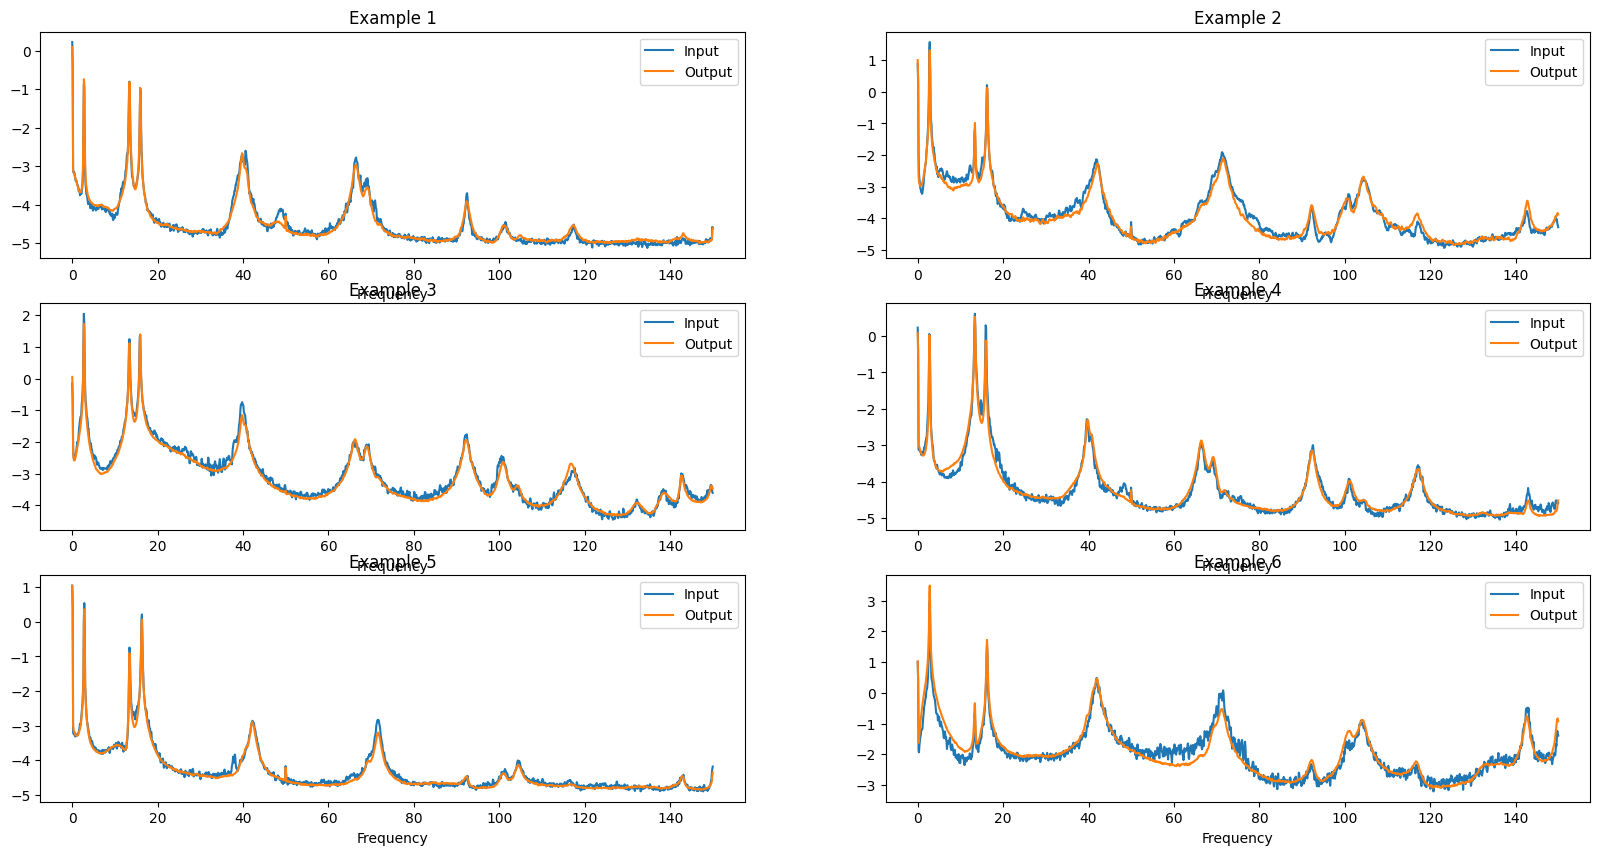

In [14]:

with torch.no_grad():
    outputs = model.model(inputs)  # Accessing the AutoEncoder within ReconstructionLoss

# Move tensors to CPU and convert to NumPy arrays
inputs_np = inputs.cpu().numpy()
outputs_np = outputs.cpu().numpy()
fig,ax = plt.subplots(3,2,figsize=(20,10))

for i in range(6):
    ax[i//2,i%2].plot(freq_axis[0:1490],inputs_np[i],label='Input')
    ax[i//2,i%2].plot(freq_axis[0:1490],outputs_np[i],label='Output')
    ax[i//2,i%2].legend()
    ax[i//2,i%2].set_title(f'Example {i+1}')
    ax[i//2,i%2].set_xlabel('Frequency')


In [15]:
# Update columns and transform_func to include 'level' or other labels
columns = ['psd', 'level','direction']  # Add any other labels you want
transform_func = [nn.Sequential(FromBuffer(),CutPSD(freq_axis=freq_axis,freq_range=(0,150))), nn.Identity(), nn.Identity()]  # Add any other transformations you want
dataset = dm.PSDDataset(
    db_path=db_path,
    columns=columns,
    transform_func=transform_func,
    query_key=query_key,
    return_dict=False,
    cached=True
)
psds = torch.stack([d[0] for d in dataset.data])
location = np.array([d[1] for d in dataset.data])
direction = np.array([d[2] for d in dataset.data])
embeddings = model.model.encode(psds).detach().cpu().numpy()


In [16]:
rms = torch.sqrt(torch.mean(psds**2, dim=1))

In [17]:
#import umap
#reducer = umap.UMAP()
#embedding_umap = reducer.fit_transform(embeddings)
from sklearn.manifold import TSNE
reducer = TSNE(n_components=2)
embedding_tsne = reducer.fit_transform(embeddings)

/tmp/ipykernel_848895/2122012181.py:22: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.scatterplot(
/tmp/ipykernel_848895/2122012181.py:31: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.scatterplot(


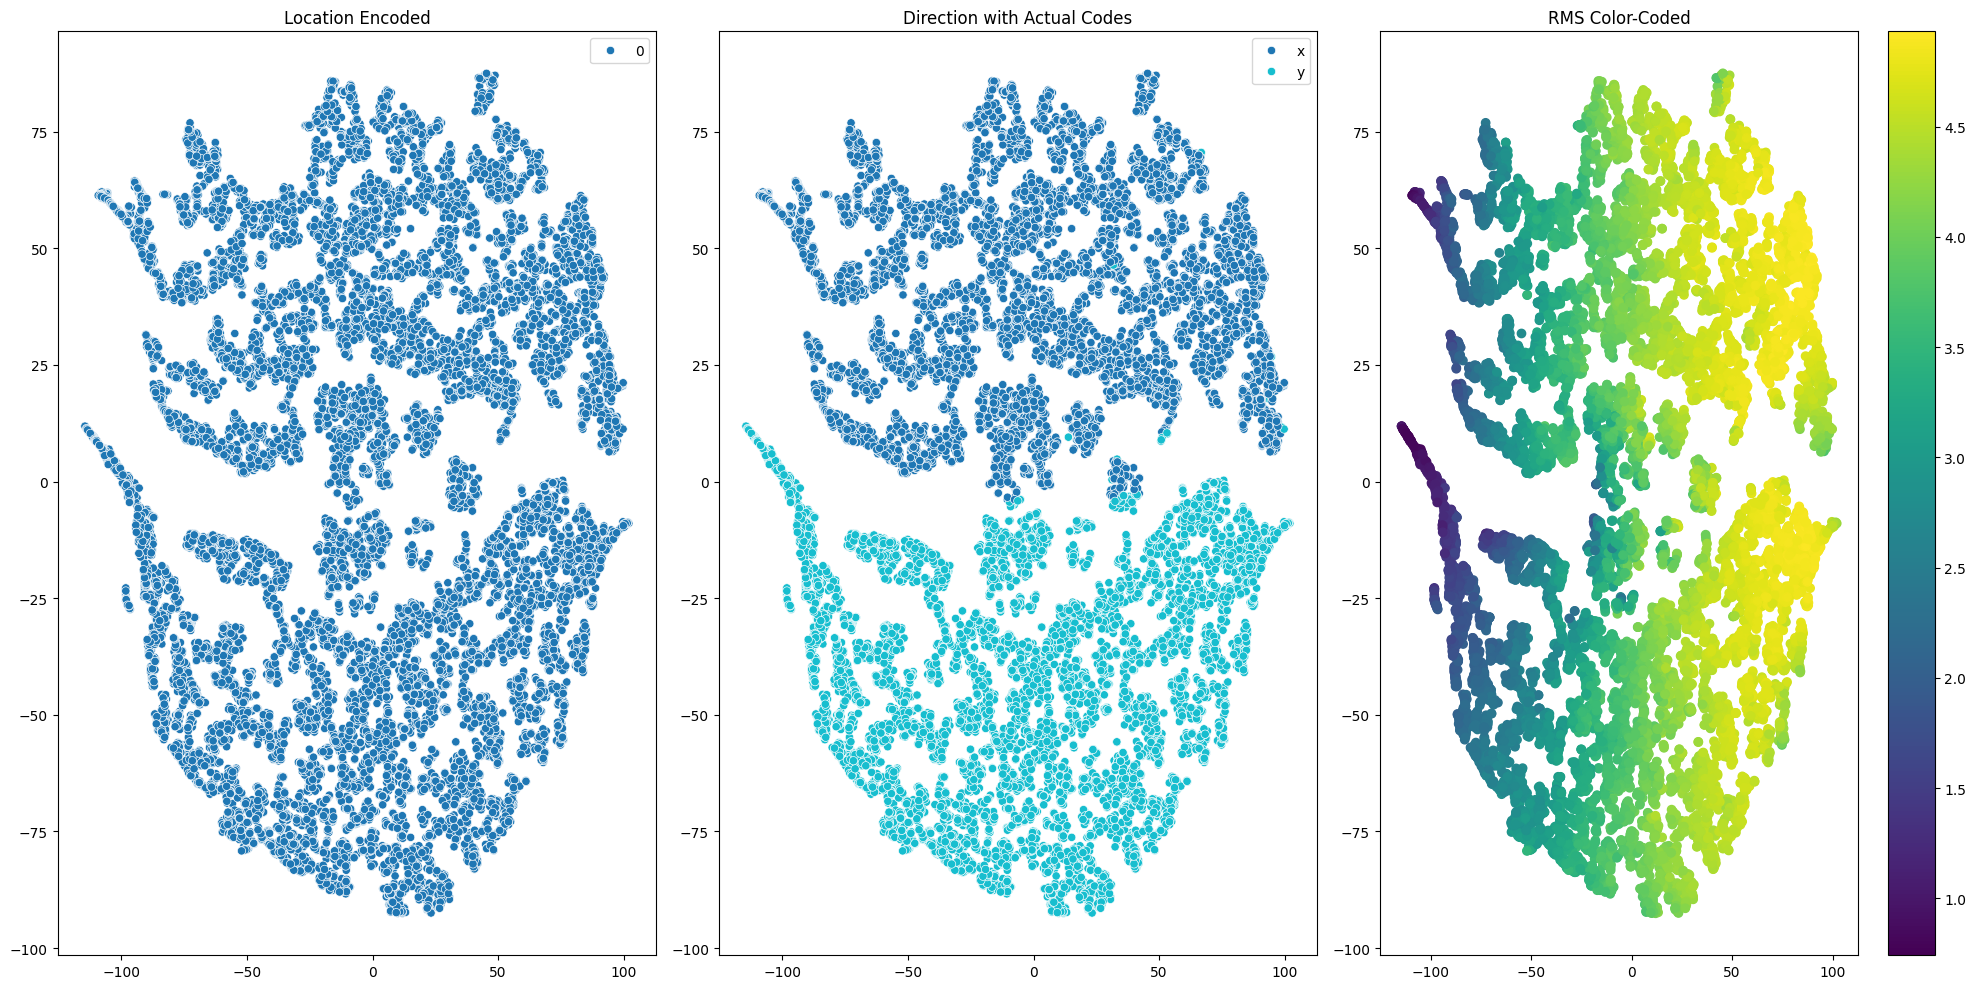

In [18]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.preprocessing import LabelEncoder
import numpy as np
import seaborn as sns

# Define unique categories for location and direction
unique_locations = np.unique(location)
unique_directions = np.unique(direction)

# Use a predefined colormap from matplotlib
location_cmap = plt.get_cmap('tab10', len(unique_locations))  # tab10 for location categories
direction_cmap = plt.get_cmap('tab10', len(unique_directions))  # Blues for direction categories

# Encode categorical variables into numeric values
location_encoded = LabelEncoder().fit_transform(location)
direction_encoded = LabelEncoder().fit_transform(direction)

fig, ax = plt.subplots(1, 3, figsize=(20, 10))

# Plot location-encoded scatter plot
sns.scatterplot(
    x=embedding_tsne[:, 0],
    y=embedding_tsne[:, 1],
    hue=location_encoded,
    palette=location_cmap.colors,
    ax=ax[0],
)

# Plot direction-encoded scatter plot, with actual labels in the legend
sns.scatterplot(
    x=embedding_tsne[:, 0],
    y=embedding_tsne[:, 1],
    hue=direction,  # Use the actual direction values instead of encoded ones
    hue_order=np.unique(direction),  # Ensure the order is the same as in the data
    palette=direction_cmap.colors,
    ax=ax[1],
)

# Scatterplot with rms and colorbar
scatter = ax[2].scatter(
    x=embedding_tsne[:, 0],
    y=embedding_tsne[:, 1],
    c=rms,
    cmap='viridis',  # Choose a colormap for rms values
)
cbar = fig.colorbar(scatter, ax=ax[2])  # Add colorbar to the figure for ax[2]

# Set titles for the subplots
ax[0].set_title('Location Encoded')
ax[1].set_title('Direction with Actual Codes')
ax[2].set_title('RMS Color-Coded')

plt.tight_layout()
plt.show()


In [ ]:
import torch
import torch.nn as nn

class Detector(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.model.eval()
        self.device = next(model.parameters()).device
        
    def mse(self, x):
        with torch.no_grad():
            x_hat = self.model(x)
        return torch.quantile((x - x_hat)**2, dim=1,q=0.9)
    def forward(self, x):
        return self.mse(x)
    
freq_axis = np.linspace(0, 825.5, 8197)
db_path = Path(settings.path.processed,'Welch(n_fft=16392, fs=1651, max_freq=825.5).db')
columns= ['psd']
transform_func = [nn.Sequential(FromBuffer(),CutPSD(freq_axis=freq_axis,freq_range=(0,150)))]
query_key = f'''y
    SELECT id FROM data
    WHERE sensor = "accel"
    AND date BETWEEN "{settings.state.healthy_train.start}" AND "{settings.state.healthy_train.end}"
    AND corrupted = 0
'''
data_loader = dm.PSDDataModule(db_path= db_path,columns=columns,transform_func=transform_func, query_key=query_key, batch_size=32, return_dict=False, cached=False)



In [ ]:
import pandas as pd

In [ ]:
detector = Detector(model.model) 
db_path = Path(settings.path.processed,'Welch(n_fft=16392, fs=1651, max_freq=825.5).db')
columns= ['psd','date','direction','level']
transform_func = [nn.Sequential(FromBuffer(),CutPSD(freq_axis=freq_axis,freq_range=(0,150))),
                                nn.Identity(),nn.Identity(),nn.Identity()]
query_key = f'''
    SELECT id FROM data
    WHERE sensor = "accel"
    AND corrupted = 0
    AND direction = "y"
'''
data_loader = dm.PSDDataModule(db_path= db_path,columns=columns,transform_func=transform_func, query_key=query_key, batch_size=10240, return_dict=False, cached=False)
data_loader.setup()

df_res = pd.DataFrame(columns=['date', 'mse', 'direction', 'level'])

for batch in data_loader.all_dataloader():
    psds = batch[0]
    dates = batch[1]
    directions = batch[2]
    levels = batch[3]
    mse = detector(psds)

                
    df_temp = pd.DataFrame({'date': dates, 'mse': mse, 'direction': directions, 'level': levels})
    df_res = pd.concat([df_res, df_temp], axis=0)    

/tmp/ipykernel_3836789/1400288588.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_res = pd.concat([df_res, df_temp], axis=0)


In [ ]:
events = settings.state.to_dict()
df_res.index = pd.to_datetime(df_res['date'])

In [ ]:
negative_mask = df_plot_meteo['airTemperatureAt2m'] < 0

start_indices = df_plot_meteo.index[negative_mask & ~negative_mask.shift(fill_value=False)]
end_indices = df_plot_meteo.index[~negative_mask & negative_mask.shift(fill_value=False)]

# Ensure lengths match (handle open-ended cases)
if len(end_indices) < len(start_indices):
    end_indices = end_indices.append(pd.Index([df_plot_meteo.index[-1]]))

# Create a DataFrame with start and end times of subzero temperature regions
date_subzero_temperature = pd.DataFrame({'start_time': start_indices, 'end_time': end_indices})


In [ ]:
date_subzero_temperature

start_time            end_time
0  2020-11-29 00:50:00 2020-11-29 08:50:00
1  2020-12-08 19:40:00 2020-12-08 20:00:00
2  2020-12-08 20:30:00 2020-12-08 22:20:00
3  2020-12-25 18:40:00 2020-12-25 19:00:00
4  2020-12-25 19:40:00 2020-12-26 02:10:00
5  2020-12-31 21:30:00 2020-12-31 21:50:00
6  2021-01-01 03:00:00 2021-01-01 03:10:00
7  2021-01-01 04:10:00 2021-01-01 05:40:00
8  2021-01-08 23:30:00 2021-01-09 05:00:00
9  2021-01-09 17:10:00 2021-01-10 06:00:00
10 2021-01-10 06:30:00 2021-01-10 06:50:00
11 2021-01-10 07:00:00 2021-01-10 07:40:00
12 2021-01-10 07:50:00 2021-01-10 08:00:00
13 2021-01-15 06:40:00 2021-01-15 08:40:00
14 2021-01-15 10:00:00 2021-01-15 10:30:00
15 2021-01-15 14:10:00 2021-01-16 13:20:00
16 2021-01-16 15:30:00 2021-01-17 13:20:00
17 2021-01-17 14:10:00 2021-01-17 22:30:00
18 2021-01-23 01:50:00 2021-01-23 02:10:00
19 2021-01-25 03:10:00 2021-01-25 09:20:00
20 2021-01-25 16:20:00 2021-01-25 16:40:00
21 2021-01-25 17:30:00 2021-01-25 20:20:00
22 2021-01-25 21:30:00 2021-01-25 21:40:00
23 2021-01-25 22:40:00 2021-01-25 23:30:00
24 2021-01-29 03:30:00 2021-01-29 06:20:00
25 2021-01-29 20:50:00 2021-01-30 11:50:00
26 2021-01-30 13:10:00 2021-01-30 13:30:00
27 2021-01-30 13:50:00 2021-01-31 10:30:00
28 2021-01-31 10:40:00 2021-01-31 10:50:00
29 2021-01-31 13:20:00 2021-02-01 20:20:00
30 2021-02-06 02:00:00 2021-02-14 14:50:00
31 2021-02-14 15:00:00 2021-02-15 11:10:00
32 2021-03-02 04:20:00 2021-03-02 04:40:00
33 2021-03-02 04:50:00 2021-03-02 08:20:00
34 2021-03-05 03:50:00 2021-03-05 08:40:00
35 2021-03-05 20:10:00 2021-03-06 07:30:00
36 2021-03-08 04:50:00 2021-03-08 06:40:00
37 2021-03-18 00:00:00 2021-03-18 00:50:00
38 2021-03-18 01:00:00 2021-03-18 01:50:00
39 2021-03-18 02:50:00 2021-03-18 07:50:00
40 2021-03-18 08:20:00 2021-03-18 08:30:00
41 2021-03-19 00:00:00 2021-03-19 06:50:00
42 2021-03-19 21:00:00 2021-03-20 09:10:00
43 2021-04-05 19:30:00 2021-04-06 00:50:00
44 2021-04-06 01:10:00 2021-04-06 01:20:00
45 2021-04-06 01:30:00 2021-04-06 04:20:00
46 2021-04-07 02:00:00 2021-04-07 02:20:00
47 2021-04-07 02:40:00 2021-04-07 05:20:00
48 2021-04-15 03:20:00 2021-04-15 05:40:00
49 2021-04-25 03:50:00 2021-04-25 04:10:00
50 2021-04-26 00:40:00 2021-04-26 02:30:00
51 2021-04-26 02:40:00 2021-04-26 05:00:00
52 2021-04-27 02:50:00 2021-04-27 03:00:00

/tmp/ipykernel_3836789/3432982005.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_res_level.loc[:,'mse_av'] = df_res_level['mse'].rolling('2H').median()
/tmp/ipykernel_3836789/3432982005.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_res_level.loc[:,'mse_av'] = df_res_level['mse'].rolling('2H').median()


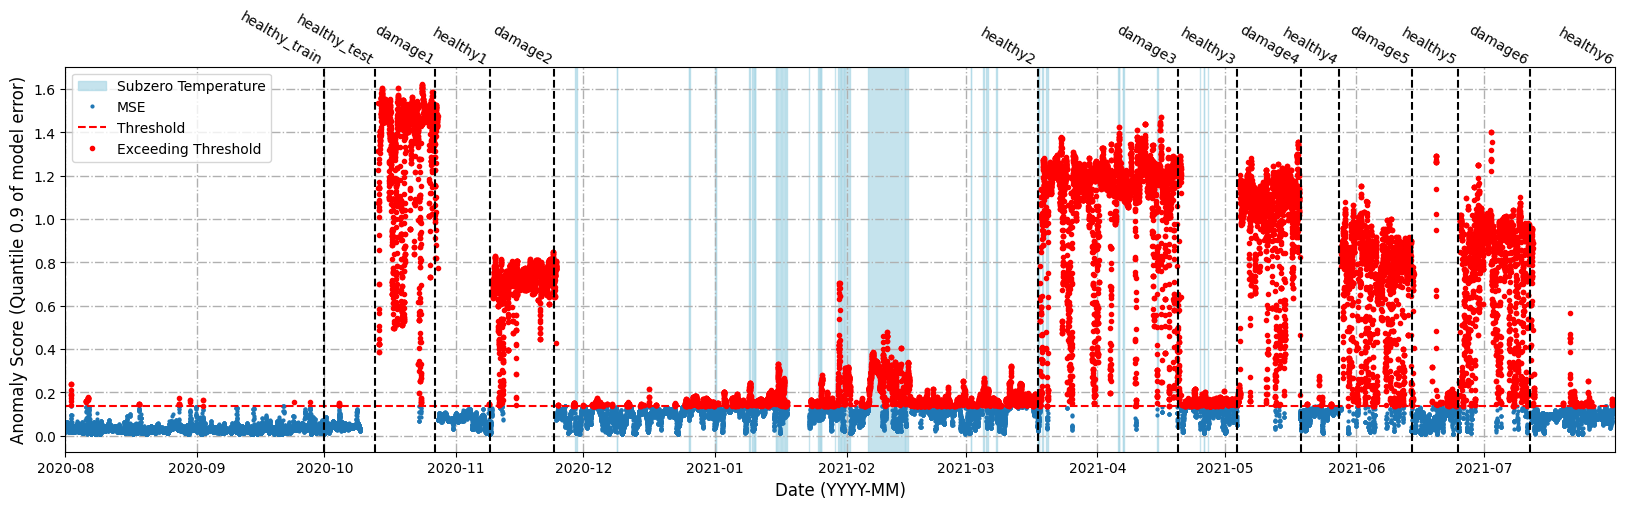

In [ ]:
import matplotlib.patches as mpatches

df_res_level = df_res[df_res['level'] == 1] 

# make a control chart 
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
df_res_level.index = pd.to_datetime(df_res_level['date'])
# average mse per hour
df_res_level.loc[:,'mse_av'] = df_res_level['mse'].rolling('2H').median()
threshold = df_res_level.query(f'date >= "{settings.state.healthy_train.start}" and date <= "{settings.state.healthy_train.end}"')['mse_av'].quantile(0.995)




ax.plot(df_res_level.index, df_res_level['mse_av'], label='MSE', marker='o', markersize=2, linestyle='', color='tab:blue')
ax.axhline(threshold, color='red', linestyle='--', label='Threshold')
# circle the points that exceed the threshold
df_res_level_exceed = df_res_level[df_res_level['mse_av'] > threshold]
ax.plot(df_res_level_exceed.index, df_res_level_exceed['mse_av'], marker='o', markersize=3, linestyle='', color='red', label='Exceeding Threshold')

for event_i in events:
    start = pd.to_datetime(events[event_i]['start'])
    end = pd.to_datetime(events[event_i]['end'])

    
    # Draw vertical line and label for event 
    
# add g
plt.legend()
ax.set_xmargin(0)
ax.grid(True, which='both', linestyle='-.', linewidth=1)
ax.set_ylabel('Anomaly Score (Quantile 0.9 of model error)', fontsize=12)
ax.set_xlabel('Date (YYYY-MM)', fontsize=12)
# add a legend for the highlighted regions showing that a highluight of light blue is for subzero temperature
subzero_patch = mpatches.Patch(color='lightblue', alpha=0.7, label='Subzero Temperature')
plt.legend(handles=[subzero_patch] + ax.get_legend_handles_labels()[0], loc='upper left')

plt.savefig('control_chart.png')
# add 


In [ ]:
from evaluation_lumo import __version__

ImportError: cannot import name '__version__' from 'evaluation_lumo' (/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/evaluation_lumo/__init__.py)

In [ ]:
from evaluation_lumo.evaluation import compute_tr_by_events, compute_mean_variation

In [ ]:
compute_tr_by_events(timestamps=df_res_level.index, anomaly_scores=df_res_level['mse'])


date
2020-10-13 16:39:00    1.314343
2020-10-13 16:49:00    1.761257
2020-10-13 16:59:00    0.917613
2020-10-13 17:09:00    1.141245
2020-10-13 17:19:00    0.648117
                         ...   
2020-10-26 23:12:00    1.265970
2020-10-26 23:22:00    1.120984
2020-10-26 23:32:00    1.444995
2020-10-26 23:42:00    1.483306
2020-10-26 23:52:00    1.473824
Name: score, Length: 1913, dtype: float32
date
2020-11-09 00:09:00    0.013223
2020-11-09 00:19:00    0.009165
2020-11-09 00:29:00    0.010706
2020-11-09 00:39:00    0.009524
2020-11-09 00:49:00    0.007800
                         ...   
2020-11-23 23:10:00    0.864777
2020-11-23 23:20:00    0.817662
2020-11-23 23:30:00    0.885262
2020-11-23 23:40:00    0.766460
2020-11-23 23:50:00    0.777627
Name: score, Length: 2135, dtype: float32
date
2021-03-18 00:09:00    0.020145
2021-03-18 00:19:00    0.022627
2021-03-18 00:29:00    0.022272
2021-03-18 00:39:00    0.039132
2021-03-18 00:49:00    0.055299
                         ...   
2021-

({'damage1': 0.9654992158912703,
  'damage2': 0.9241217798594847,
  'damage3': 0.9165962837837838,
  'damage4': 0.8873435326842837,
  'damage5': 0.7565573770491804,
  'damage6': 0.7752255947497949,
  'healthy1': 0.04924242424242424,
  'healthy2': 0.061099406244014554,
  'healthy3': 0.06405163853028799,
  'healthy4': 0.029343629343629343,
  'healthy5': 0.07628734901462174,
  'healthy6': 0.04794996525364837,
  'healthy_test': 0.002497918401332223,
  'healthy_train': 0.010046808996460783},
 np.float32(0.27496076))

In [ ]:
from hannover_pylon.utils.evaluation import label_dataframe_event , compute_TPR,cohens_d, ks_test

compute_tr_by_events(timestamps=df_res_level.index, anomaly_scores=df_res_level['mse_av'])
compute_mean_variation(timestamps=df_res_level.index, anomaly_scores=df_res_level['mse_av'])

date
2020-10-13 16:39:00    1.314343
2020-10-13 16:49:00    1.537800
2020-10-13 16:59:00    1.314343
2020-10-13 17:09:00    1.227794
2020-10-13 17:19:00    1.141245
                         ...   
2020-10-26 23:12:00    1.225011
2020-10-26 23:22:00    1.152518
2020-10-26 23:32:00    1.152518
2020-10-26 23:42:00    1.152518
2020-10-26 23:52:00    1.152518
Name: score, Length: 1913, dtype: float64
date
2020-11-09 00:09:00    0.023969
2020-11-09 00:19:00    0.023969
2020-11-09 00:29:00    0.023969
2020-11-09 00:39:00    0.023969
2020-11-09 00:49:00    0.023969
                         ...   
2020-11-23 23:10:00    0.752583
2020-11-23 23:20:00    0.764205
2020-11-23 23:30:00    0.771415
2020-11-23 23:40:00    0.771415
2020-11-23 23:50:00    0.776899
Name: score, Length: 2135, dtype: float64
date
2021-03-18 00:09:00    0.051368
2021-03-18 00:19:00    0.045395
2021-03-18 00:29:00    0.034082
2021-03-18 00:39:00    0.039800
2021-03-18 00:49:00    0.039800
                         ...   
2021-

{'damage1': 165.1662764982951,
 'damage2': 86.11251014584839,
 'damage3': 132.5820249228043,
 'damage4': 119.3460849457525,
 'damage5': 78.3597581991453,
 'damage6': 88.30590803071765,
 'healthy1': 16.90429136880525,
 'healthy2': 16.538006060765863,
 'healthy3': 19.45429958506316,
 'healthy4': 13.170902278357653,
 'healthy5': 13.790569528662747,
 'healthy6': 13.089223689602692,
 'healthy_test': 5.862936088963215,
 'healthy_train': 4.284524260834473}

In [ ]:
df_plot_meteo.index = df_plot_meteo.index + pd.Timedelta(minutes=10)   

In [ ]:
df_res_level_meteo = pd.merge_asof(df_res_level,df_plot_meteo, 
                            left_index=True, right_index=True, direction='nearest')
df_res_level_meteo.columns

Index(['date', 'mse', 'direction', 'level', 'mse_av', 'airTemperatureAt2m',
       'avgWindSpeedAt10m', 'globalRadiation', 'maxWindSpeedAt10m',
       'precipitation', 'relHumidityAt2m', 'windDirection'],
      dtype='object')

In [ ]:
df_res_level_meteo

date       mse direction level    mse_av  \
date                                                                           
2020-08-01 00:02:00  2020-08-01 00:02:00  0.019951         y     1  0.019951   
2020-08-01 00:12:00  2020-08-01 00:12:00  0.027414         y     1  0.023682   
2020-08-01 00:22:00  2020-08-01 00:22:00  0.011137         y     1  0.019951   
2020-08-01 00:32:00  2020-08-01 00:32:00  0.010211         y     1  0.015544   
2020-08-01 00:42:00  2020-08-01 00:42:00  0.054214         y     1  0.019951   
...                                  ...       ...       ...   ...       ...   
2021-07-31 23:16:00  2021-07-31 23:16:00  0.096890         y     1  0.104286   
2021-07-31 23:26:00  2021-07-31 23:26:00  0.092655         y     1  0.104286   
2021-07-31 23:36:00  2021-07-31 23:36:00  0.098120         y     1  0.104286   
2021-07-31 23:46:00  2021-07-31 23:46:00  0.082660         y     1  0.100106   
2021-07-31 23:56:00  2021-07-31 23:56:00  0.046625         y     1  0.100106   

                     airTemperatureAt2m  avgWindSpeedAt10m  globalRadiation  \
date                                                                          
2020-08-01 00:02:00           18.420000               1.65              0.0   
2020-08-01 00:12:00           18.420000               1.65              0.0   
2020-08-01 00:22:00           18.130001               1.30              0.0   
2020-08-01 00:32:00           17.230000               0.25              0.0   
2020-08-01 00:42:00           17.049999               0.00              0.0   
...                                 ...                ...              ...   
2021-07-31 23:16:00                 NaN               1.62              NaN   
2021-07-31 23:26:00                 NaN               1.62              NaN   
2021-07-31 23:36:00                 NaN               1.62              NaN   
2021-07-31 23:46:00                 NaN               1.62              NaN   
2021-07-31 23:56:00                 NaN               1.62              NaN   

                     maxWindSpeedAt10m  precipitation  relHumidityAt2m  \
date                                                                     
2020-08-01 00:02:00               2.02            0.0        71.729996   
2020-08-01 00:12:00               2.02            0.0        71.729996   
2020-08-01 00:22:00               1.03            0.0        72.410004   
2020-08-01 00:32:00               0.00            0.0        74.199997   
2020-08-01 00:42:00               0.10            0.0        77.209999   
...                                ...            ...              ...   
2021-07-31 23:16:00               1.94            NaN              NaN   
2021-07-31 23:26:00               1.94            NaN              NaN   
2021-07-31 23:36:00               1.94            NaN              NaN   
2021-07-31 23:46:00               1.94            NaN              NaN   
2021-07-31 23:56:00               1.94            NaN              NaN   

                     windDirection  
date                                
2020-08-01 00:02:00     107.400002  
2020-08-01 00:12:00     107.400002  
2020-08-01 00:22:00     130.000000  
2020-08-01 00:32:00     138.699997  
2020-08-01 00:42:00     125.000000  
...                            ...  
2021-07-31 23:16:00     142.600006  
2021-07-31 23:26:00     142.600006  
2021-07-31 23:36:00     142.600006  
2021-07-31 23:46:00     142.600006  
2021-07-31 23:56:00     142.600006  

[51050 rows x 12 columns]

In [ ]:
df_res_level_meteo_h3

NameError: name 'df_res_level_meteo_h3' is not defined

In [ ]:
# Import necessary libraries
from scipy.stats import pearsonr
import pandas as pd
import matplotlib.pyplot as plt

# Drop NaNs in 'mse' or 'airTemperatureAt2m'
df_res_level_meteo = df_res_level_meteo.dropna(subset=['mse', 'airTemperatureAt2m'])

# Filter data for specific labels
df_res_level_meteo_test = df_res_level_meteo.query('label == "healthy_test"')
df_res_level_meteo_h3 = df_res_level_meteo.query('label == "healthy2"')

# Create subplots
fig, ax = plt.subplots(figsize=(20, 10))

# First subplot
ax.scatter(df_res_level_meteo_test['airTemperatureAt2m'], df_res_level_meteo_test['mse'])
ax.set_xlabel('Temperature')
ax.set_ylabel('MSE')
ax.set_title('Temperature vs MSE (healthy_test)')

# Compute and display Pearson correlation coefficient
corr, _ = pearsonr(df_res_level_meteo_test['airTemperatureAt2m'], df_res_level_meteo_test['mse'])
ax.text(0.05, 0.95, f'Pearson correlation: {corr:.2f}', fontsize=12, transform=ax.transAxes, verticalalignment='top')




UndefinedVariableError: name 'label' is not defined

In [ ]:
df_res_level_meteo_h3['maxWindSpeedAt10m'].hist()

NameError: name 'df_res_level_meteo_h3' is not defined

In [ ]:
# Import necessary libraries
from scipy.stats import pearsonr, t
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Ensure df_res_level_meteo_h3 is a copy to avoid SettingWithCopyWarning
df_res_level_meteo_h3 = df_res_level_meteo_h3.copy()

# Bin over temperature with 20 bins
df_res_level_meteo_h3['temp_bin'] = pd.cut(df_res_level_meteo_h3['airTemperatureAt2m'], bins=30)

# Group by temperature bins
grouped = df_res_level_meteo_h3.groupby('temp_bin')

# Compute mean MSE per bin
mean_mse = grouped['mse'].mean()

# Compute standard deviation per bin
std_mse = grouped['mse'].std()

# Compute the number of observations per bin
count_mse = grouped['mse'].count()

# Compute standard error of the mean
sem_mse = std_mse / np.sqrt(count_mse)

# Compute t critical value for 95% confidence interval
confidence_level = 0.95
degrees_of_freedom = count_mse - 1

# Handle degrees of freedom less than 1
degrees_of_freedom[degrees_of_freedom < 1] = np.nan

# Compute t critical values
t_critical = t.ppf((1 + confidence_level) / 2, degrees_of_freedom)

# Compute margin of error
margin_of_error = t_critical * sem_mse

# Access the intervals from the categories
intervals = mean_mse.index.categories

# Extract midpoints of the intervals
x_values = intervals.mid

# **Identify bins with valid confidence intervals and n >= 100**
valid_bins = (~np.isnan(margin_of_error)) & (count_mse >= 100)

# Filter data accordingly
x_values_filtered = x_values[valid_bins]
mean_mse_filtered = mean_mse.values[valid_bins]
margin_of_error_filtered = margin_of_error.values[valid_bins]
count_mse_filtered = count_mse.values[valid_bins]

# Plot the mean MSE per bin vs temperature with error bars
plt.figure(figsize=(12, 6))
plt.errorbar(
    x_values_filtered,
    mean_mse_filtered,
    yerr=margin_of_error_filtered,
    fmt='o-',
    capsize=5,
    ecolor='gray',
    elinewidth=1,
    markeredgewidth=1,
    label='Mean MSE with 95% CI'
)

# Add the number of samples per point
for x, y, n in zip(x_values_filtered, mean_mse_filtered, count_mse_filtered):
    plt.annotate(f'n={int(n)}', xy=(x, y), xytext=(0, 8), textcoords='offset points', ha='center', fontsize=9)

plt.xlabel('Temperature (Midpoint of Bins)')
plt.ylabel('Mean MSE')
plt.title('Mean MSE per Temperature Bin (n ≥ 100) with 95% Confidence Intervals (healthy2)')
plt.grid(True)
plt.legend()
plt.show()


NameError: name 'df_res_level_meteo_h3' is not defined

In [ ]:
from matplotlib.ticker import FuncFormatter

def create_date_formatter(column_dates):
    """Return a custom formatter function for datetime labels."""
    def custom_date_format(x, pos=None):
        if 0 <= int(x) < len(column_dates):
            return column_dates[int(x)].strftime('%d-%b-%Y')
        return ''  # Return empty string if out of range
    return FuncFormatter(custom_date_format)

# Apply the custom date formatter

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
from matplotlib.patches import Rectangle
import pandas as pd
import numpy as np
from functools import partial

# Filter the dataframe for 'y' direction and pivot the data for the heatmap
df_res['date'] = pd.to_datetime(df_res['date'])
df_res_y = df_res[df_res['direction'] == 'y']
df_pivot = df_res_y.pivot_table(index='level', columns=['date'], values='mse', aggfunc='mean')
# average the mse over 1hours rolling window with 1 hour step
df_pivot = df_pivot.T.rolling('1D', min_periods=1).mean().T# Create the heatmap plot
fig, ax = plt.subplots(1, 1, figsize=(20, 10))

# Plot the heatmap with seaborn
df_pivot.columns = pd.to_datetime(df_pivot.columns)

sns.heatmap(
    df_pivot, 
    cmap='seismic',  # Set the color map to 'seismic' for highlighting extremes
    cbar_kws={'label': 'Mean MSE'},  # Add a color bar label
    ax=ax,
    center=0.3
)
# Set axis labels and title
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Level', fontsize=14)
ax.xaxis.set_major_formatter(create_date_formatter(df_pivot.columns))
ax.xaxis.set_major_locator(MaxNLocator(nbins=15))  # Set the maximum number of ticks

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

for event_i in events:
    start = pd.to_datetime(events[event_i]['start'])
    end = pd.to_datetime(events[event_i]['end'])
    idx_start = np.cumsum(df_pivot.columns < start)[-1]
    idx_end = np.cumsum(df_pivot.columns < end)[-1]
    
    # Draw vertical line and label for event
    ax.axvline(idx_start, color='black', linestyle='--', label=f'{event_i} start')
    ax.text(idx_start, -0.1, f'{event_i}', rotation=90, va='bottom', ha='left')
    
    # Draw horizontal line for the closest sensor level during the event
    level = events[event_i].get('closest_sensor', None)
    if level is not None:
        ax.axhline(level - 0.5, xmin=idx_start / len(df_pivot.columns), xmax=idx_end / len(df_pivot.columns), 
                   color='green', linestyle='-', lw=5, alpha=0.5)
    
    # Draw a box above the plot to indicate severity
    severity = events[event_i].get('severity', None)
    if severity is not None:
        color = 'red' if severity == 'high' else 'yellow'
        # Add rectangle patch above the plot to indicate severity
        box_height = 0.05  # Height of the box
        ax.add_patch(Rectangle(
            (idx_start, 1),  # Starting point of the box (above the plot)
            width=idx_end - idx_start,                # Width of the box
            height=box_height,                        # Height of the box
            color=color, 
            alpha=0.5,
            transform=ax.get_xaxis_transform(),       # Transform to place above the x-axis
            clip_on=False                             # Make sure the rectangle is not clipped
        ))
        ax.text((idx_start + idx_end) / 2, -0.1+ box_height, 'severity \n'+severity, ha='center', va='bottom', color='black')
# Tighten the layout
plt.tight_layout()
plt.savefig('ControlChart_AE_PSD_version_1.png')

# Show the plot
plt.show()


ValueError: 'date' is both an index level and a column label, which is ambiguous.

In [ ]:
query_key = f'''
    SELECT id FROM data
    WHERE sensor = "accel" 
    AND level = '1'
    AND date BETWEEN "{settings.state.healthy_test.start}" AND "{settings.state.healthy_test.end}"
    AND corrupted = 0
    AND direction = "y"
'''
data_loader = dm.PSDDataModule(db_path= db_path,columns=columns,transform_func=transform_func, query_key=query_key, batch_size=10240, return_dict=False, cached=False)
data_loader.setup()

df_res = pd.DataFrame(columns=['date', 'mse', 'direction', 'level'])
all_psds = []
all_dates = []
all_directions = []
all_levels = []

for batch in data_loader.all_dataloader():
    all_psds.append(batch[0])
    all_dates.append(batch[1])
    all_directions.append(batch[2])
    all_levels.append(batch[3])
all_psds = torch.cat(all_psds)

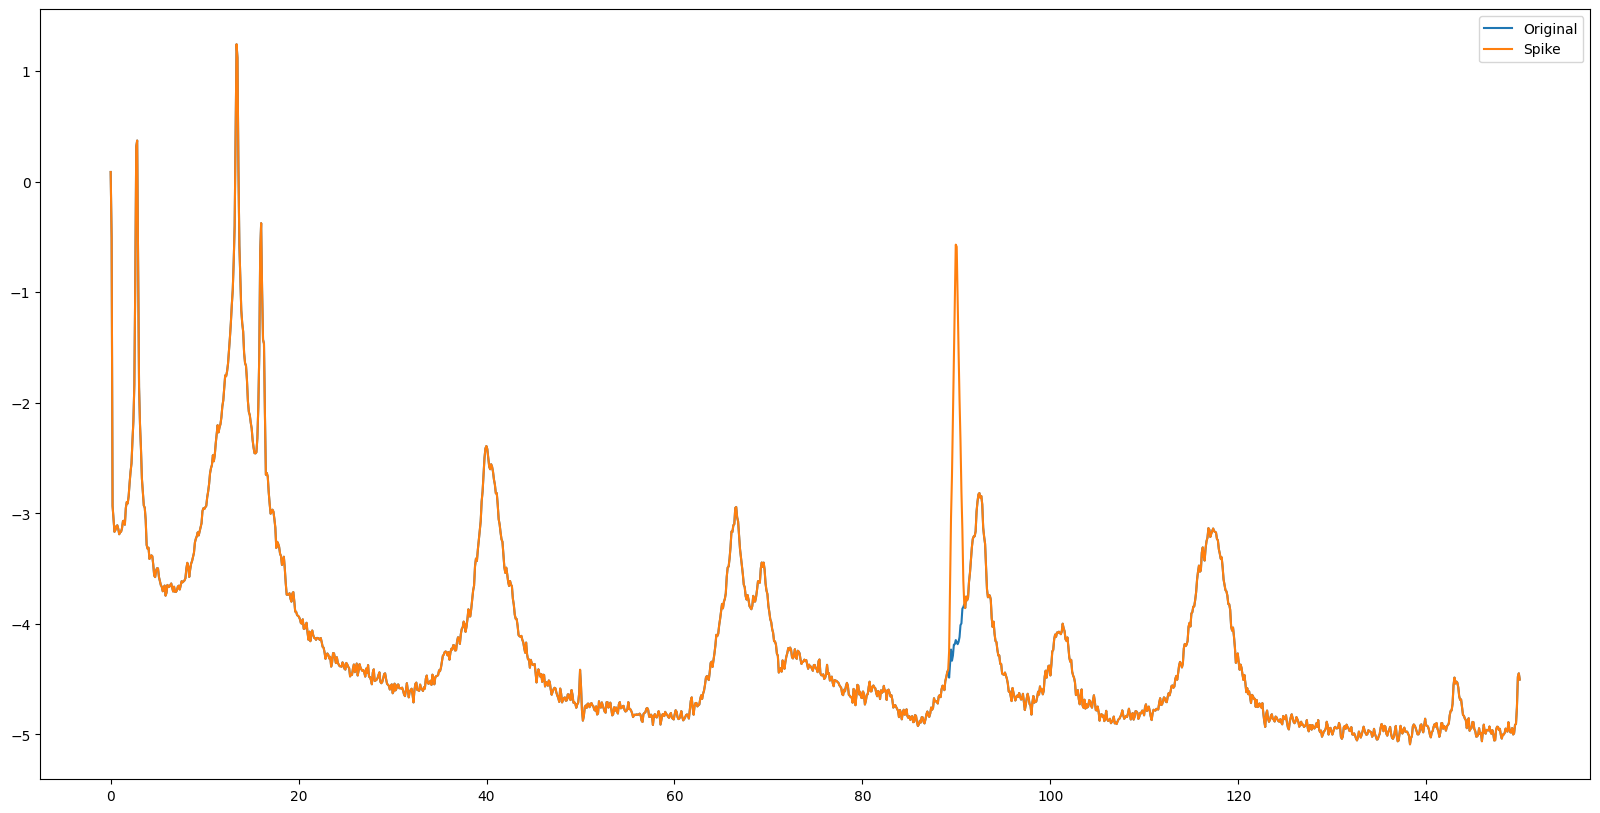

In [ ]:
import virtual_anomaly as va
window_center= 5
amplitude = 0.4
psd_aff = va.AddSpike(freq_axis[0:1490],90,0.8,amplitude)(all_psds).T
fig,ax = plt.subplots(1,1,figsize=(20,10))
ax.plot(freq_axis[0:1490],all_psds[0],label='Original')
ax.plot(freq_axis[0:1490],psd_aff[0],label='Spike')
ax.legend()


In [ ]:
all_psds.shape

torch.Size([1201, 1490])

In [ ]:
from sklearn.metrics import roc_auc_score
amplitudes = np.arange(-0.5,0.5,0.03)
# arround the amplitude to  2 decimal
amplitudes = np.round(amplitudes,2)
window_centers = np.arange(0,150,1)
df_va = []
healthy_score = detector(all_psds)
for amplitude in amplitudes:
    for window_center in window_centers:
        psd_aff = va.AddSpike(freq_axis[0:1490],window_center,0.8,amplitude)(all_psds).T
        affected_score = detector(psd_aff)
        labels = np.array([1] * len(healthy_score) + [0] * len(affected_score))
        scores = np.concatenate([affected_score, healthy_score])
        aucs_res = roc_auc_score(labels, scores)
        df_va.append({'amplitude':amplitude,'window_center':window_center,'auc':aucs_res})
        
        



In [ ]:
df_va = pd.DataFrame(df_va)

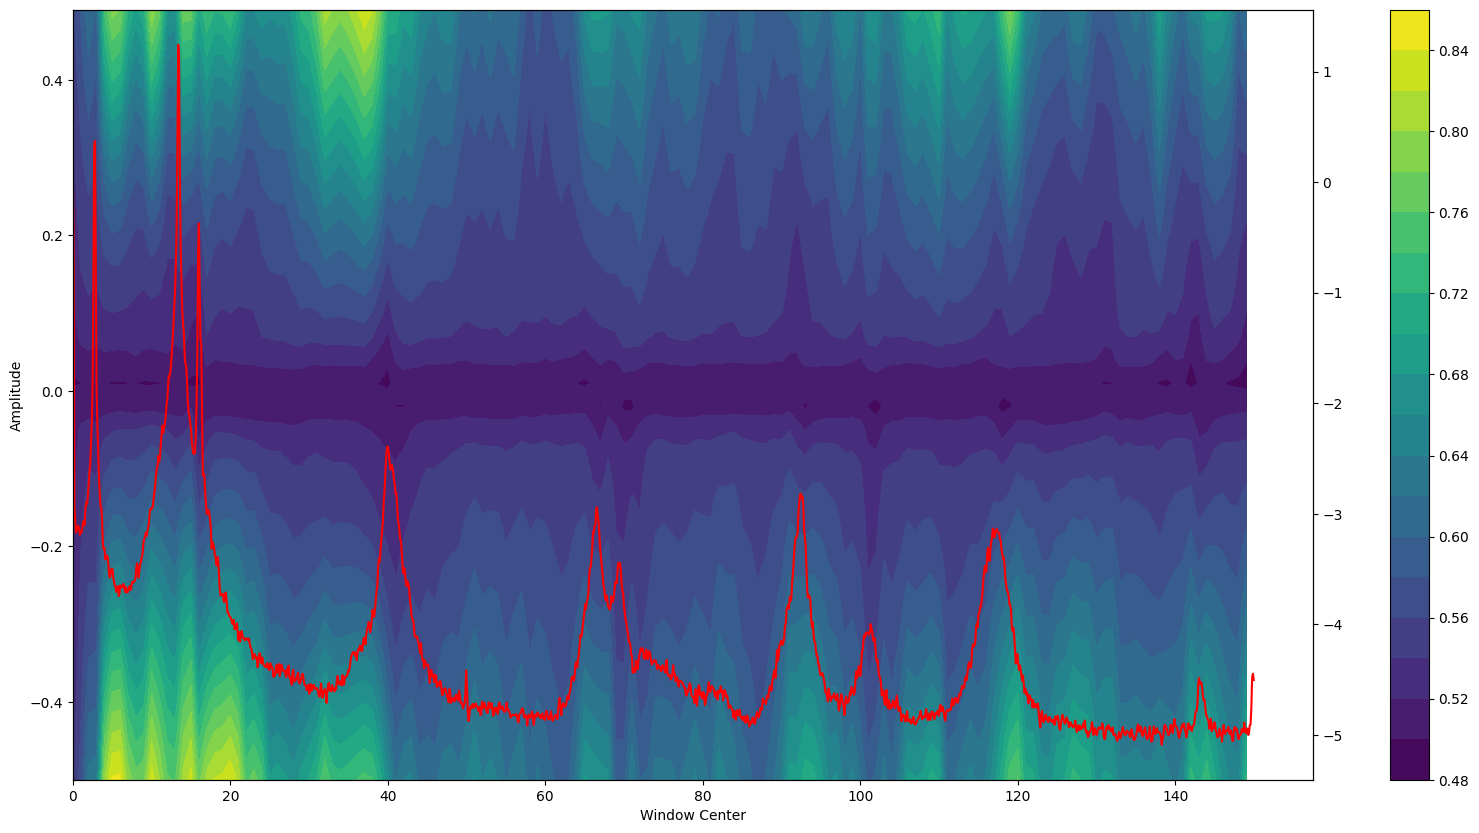

In [ ]:
import seaborn as sns
heat = df_va.pivot_table(index='amplitude',columns='window_center',values='auc')
x,y = np.meshgrid(window_centers,amplitudes)
z = heat.values
fig,ax = plt.subplots(1,1,figsize=(20,10))
contour = ax.contourf(x,y,z,cmap='viridis',levels=20)
ax.set_xlabel('Window Center')
ax.set_ylabel('Amplitude')
fig.colorbar(contour, ax=ax)
ax1 = ax.twinx()
ax1.plot(freq_axis[0:1490],all_psds[0],label='Spike',color='red')

In [ ]:
torch.from_numpy(freq_axis[0:1490]).shape

torch.Size([1490])

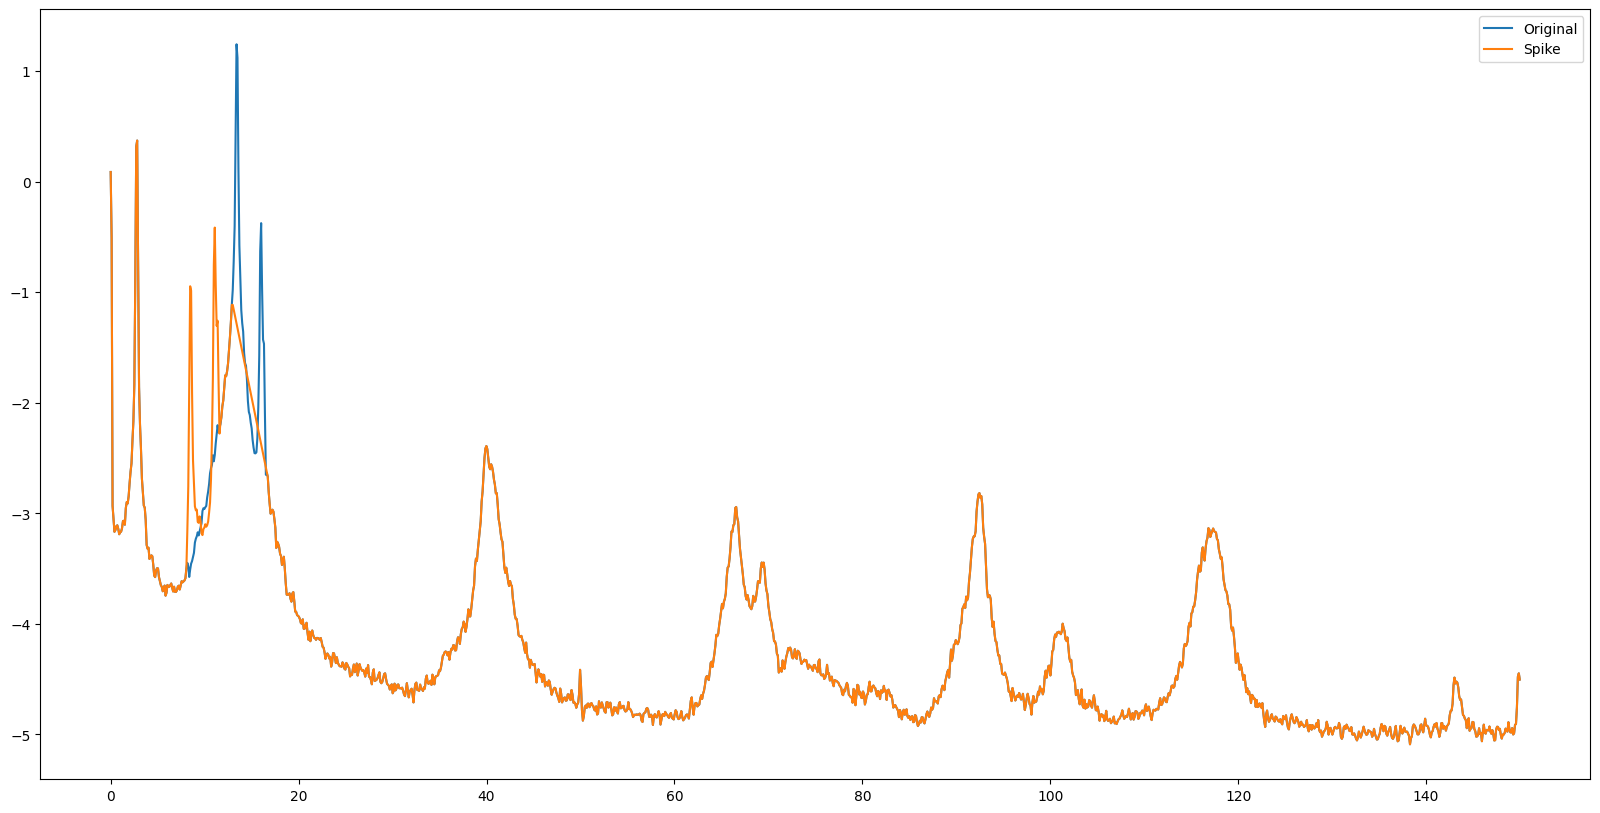

In [ ]:
import virtual_anomaly as va
window_center= 5
amplitude = 0.4
tsf = va.DelayPart(torch.from_numpy(freq_axis[0:1490]),
                   15, 5,2,remove_artifacts=True)
psd_aff = tsf(all_psds)
fig,ax = plt.subplots(1,1,figsize=(20,10))
ax.plot(freq_axis[0:1490],all_psds[0],label='Original')
ax.plot(freq_axis[0:1490],psd_aff[0],label='Spike')
ax.legend()


In [ ]:
from sklearn.metrics import roc_auc_score
amplitudes_shift = np.arange(-4,4,0.5)
# arround the amplitude to  2 decimal
amplitudes = np.round(amplitudes,2)
window_centers = np.arange(5,145,1)
df_va = []
healthy_score = detector(all_psds)
for amplitude in amplitudes:
    for window_center in window_centers:
        psd_aff = va.DelayPart(freq_axis[0:1490],
                               window_center= window_center,
                               delay= amplitude,
                                window_size= 2,remove_artifacts=True)(all_psds)
        affected_score = detector(psd_aff)
        labels = np.array([1] * len(healthy_score) + [0] * len(affected_score))
        scores = np.concatenate([affected_score, healthy_score])
        aucs_res = roc_auc_score(labels, scores)
        df_va.append({'amplitude':amplitude,'window_center':window_center,'auc':aucs_res})
        
        



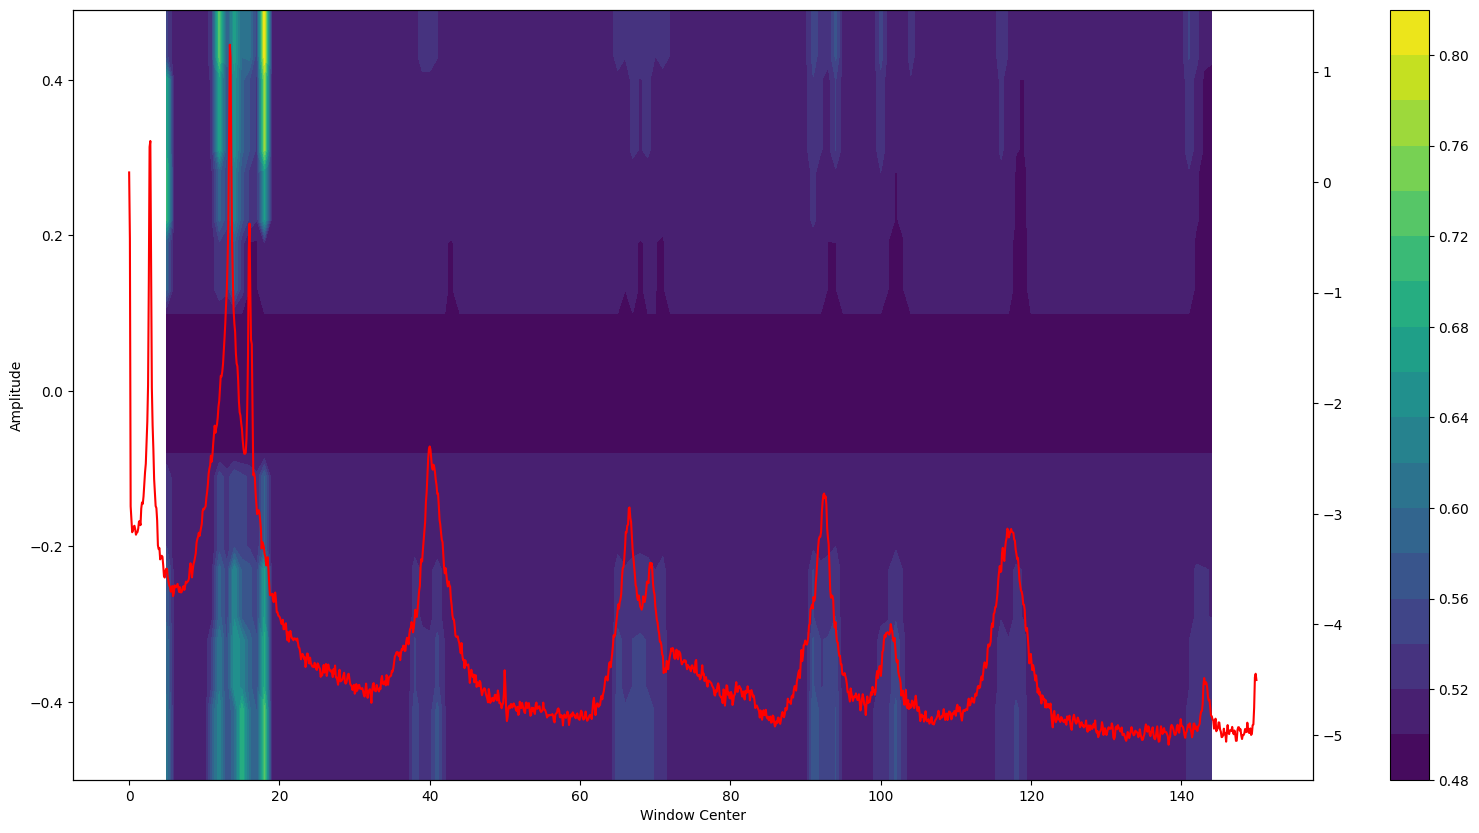

In [ ]:
df_va = pd.DataFrame(df_va)
import seaborn as sns
heat = df_va.pivot_table(index='amplitude',columns='window_center',values='auc')
x,y = np.meshgrid(window_centers,amplitudes)
z = heat.values
fig,ax = plt.subplots(1,1,figsize=(20,10))
contour = ax.contourf(x,y,z,cmap='viridis',levels=20)
ax.set_xlabel('Window Center')
ax.set_ylabel('Amplitude')
fig.colorbar(contour, ax=ax)
ax1 = ax.twinx()
ax1.plot(freq_axis[0:1490],all_psds[0],label='Spike',color='red')

# Convolution AE

In [ ]:
import torch
import torch.nn as nn
class NormLayer(nn.Module):
    def __init__(self, max_val, min_val, denormalize=False):
        super(NormLayer, self).__init__()
        self.register_buffer('max', self._to_tensor(max_val))
        self.register_buffer('min', self._to_tensor(min_val))
        self.denormalize = denormalize
        self.forward_func = {False: self.forward_norm, True: self.forward_denorm}
        self.forward = self.forward_func[self.denormalize]

    def forward_norm(self, x):
        return (x - self.min) / (self.max - self.min + 1e-8)

    def forward_denorm(self, x):
        return x * (self.max - self.min + 1e-8) + self.min

    def _to_tensor(self, val):
        if isinstance(val, torch.Tensor):
            return val.clone().detach()
        else:
            return torch.tensor(val, dtype=torch.float32)
        
class UnsqueezeLayer(nn.Module):
    def __init__(self, dim=1):
        super(UnsqueezeLayer, self).__init__()
        self.dim = dim

    def forward(self, x):
        x = x.unsqueeze(self.dim)
        return x

class SqueezeLayer(nn.Module):
    def __init__(self, dim=1):
        super(SqueezeLayer, self).__init__()
        self.dim = dim

    def forward(self, x):
        x = x.squeeze(self.dim)
        return x

class AutoEncoderConv(nn.Module):
    def __init__(self,input_size):
        super(AutoEncoderConv, self).__init__()
        
        self.encoder = nn.Sequential(
            NormLayer(max_val = 4.96, min_val = -5.46),
            UnsqueezeLayer(1),
            nn.Conv1d(in_channels=1, out_channels=16, kernel_size=25, stride=5, padding=1),
            nn.BatchNorm1d(16),
            nn.LeakyReLU(),
            nn.Conv1d(in_channels=16, out_channels=64, kernel_size=25, stride=10, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(in_channels=64, out_channels=16, kernel_size=30, stride=1, padding=1),
            SqueezeLayer(-1),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(16, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 512),

            nn.LeakyReLU(),

            nn.Linear(512, input_size),
            NormLayer(max_val = 4.96, min_val = -5.46, denormalize=True)
        )

        # Register buffers for tracking reconstruction errors
        self.register_buffer('rec_err', torch.tensor(0.0))

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def forward_embedding(self, x):
        return self.encoder(x)
    
    def update_rec_err(self, rec_err):
        self.rec_err = rec_err
        
import pytorch_lightning as pl
class ReconstructionLoss(pl.LightningModule):
    def __init__(self,input_size):
        super(ReconstructionLoss, self).__init__()
        self.input_size = input_size
        self.model = AutoEncoderConv(input_size)
        self.loss = nn.MSELoss()
        self.save_hyperparameters()
    def forward(self, x):
        x_hat = self.model(x)
        return self.loss(x_hat, x)

    def training_step(self, batch, batch_idx):
        x = batch[0]
        loss = self(x)

        self.log('train_loss', loss,on_epoch=True,prog_bar=True,logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x = batch[0]
        loss = self(x)
        self.log('val_loss', loss,on_epoch=True,prog_bar=True,logger=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        return optimizer
    

In [ ]:
import numpy as np

freq_axis = np.linspace(0, 825.5, 8197)
db_path = Path(settings.path.processed,'Welch(n_fft=16392, fs=1651, max_freq=825.5).db')
columns= ['psd']
transform_func = [nn.Sequential(FromBuffer(),CutPSD(freq_axis=freq_axis,freq_range=(0,150)))]
query_key = f'''
    SELECT id FROM data
    WHERE sensor = "accel"
    AND date BETWEEN "{settings.state.healthy_train.start}" AND "{settings.state.healthy_train.end}"
    AND corrupted = 0
'''
data_loader = dm.PSDDataModule(db_path= db_path,columns=columns,transform_func=transform_func, query_key=query_key, batch_size=32, return_dict=False, cached=False)


In [ ]:
# free up all gpu memory
import torch, gc
torch.set_float32_matmul_precision("medium")
gc.collect()
print('Memory allocated:', torch.cuda.memory_allocated())
print('Memory cached:', torch.cuda.memory_reserved())
torch.cuda.empty_cache()
print('Memory allocated:', torch.cuda.memory_allocated())
print('Memory cached:', torch.cuda.memory_reserved())


Memory allocated: 0
Memory cached: 0
Memory allocated: 0
Memory cached: 0


In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint 
from pytorch_lightning.loggers import MLFlowLogger
mlflow = MLFlowLogger(experiment_name='AE',
                      log_model=True,
                      save_dir=settings.path.mlflow[1:])
checkpoint_callback = ModelCheckpoint(monitor='val_loss', save_top_k=1, filename='CAE-{epoch:02d}-{val_loss:.2f}')

model = ReconstructionLoss(input_size=1490) 
trainer = pl.Trainer(max_epochs=20, logger=mlflow, callbacks=[checkpoint_callback])
trainer.fit(model, data_loader)



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type            | Params | Mode 
--------------------------------------------------
0 | model | AutoEncoderConv | 889 K  | train
1 | loss  | MSELoss         | 0      | train
--------------------------------------------------
889 K     Trainable params
0         Non-trainable params
889 K     Total params
3.558     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


Epoch 19: 100%|██████████| 3942/3942 [00:17<00:00, 225.68it/s, v_num=65b9, train_loss_step=0.0133, val_loss=0.0111, train_loss_epoch=0.00999] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 3942/3942 [00:17<00:00, 225.65it/s, v_num=65b9, train_loss_step=0.0133, val_loss=0.0111, train_loss_epoch=0.00999]


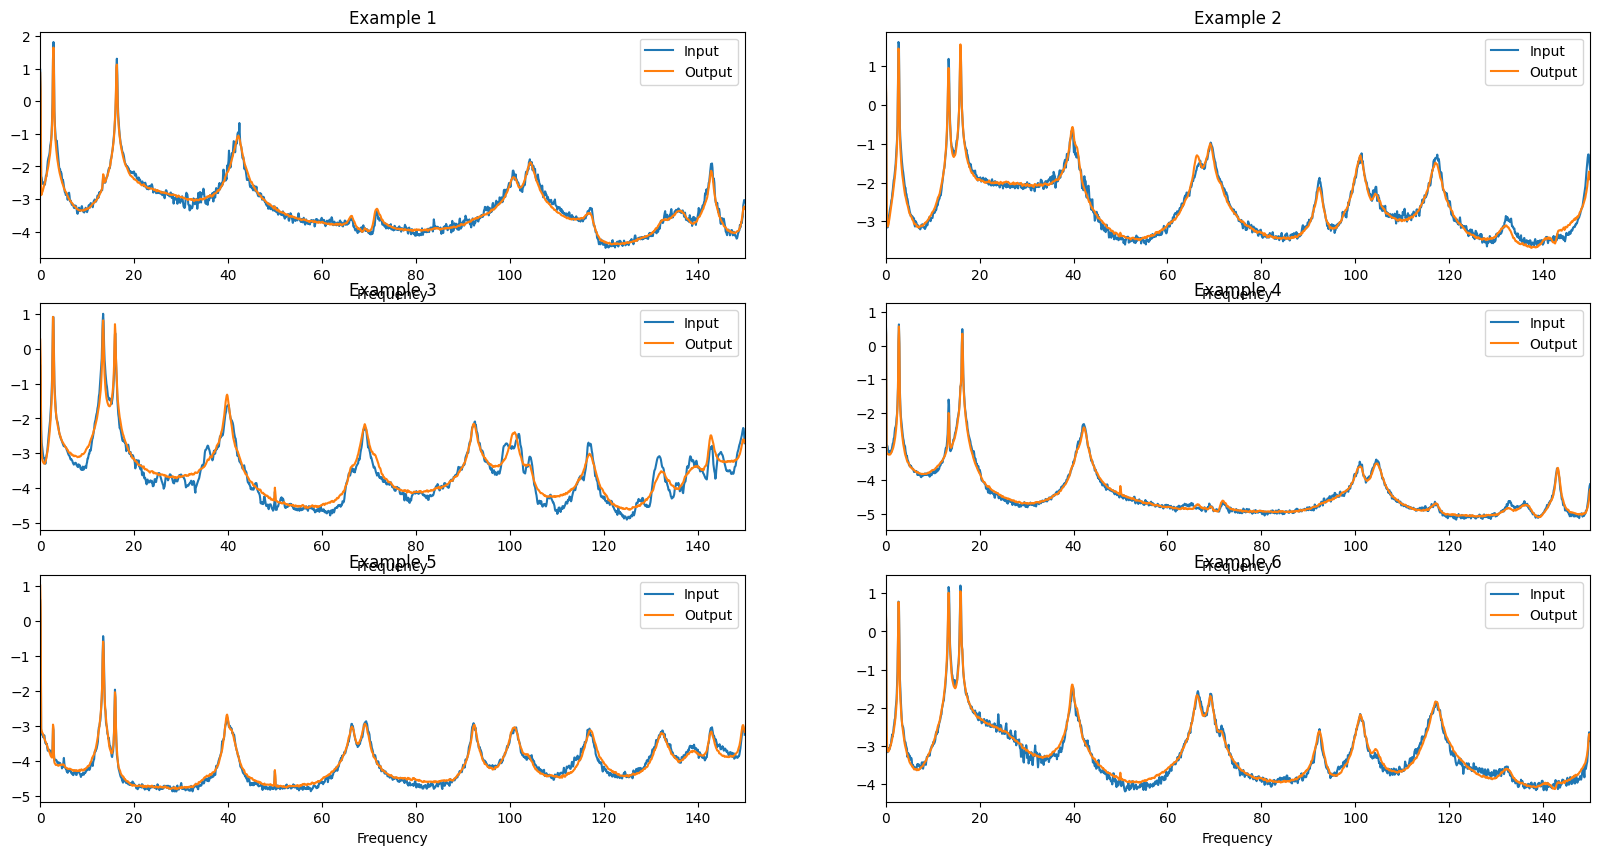

In [ ]:
model.eval()
batch = next(iter(data_loader.val_dataloader()))
inputs = batch[0]
with torch.no_grad():
    outputs = model.model(inputs)  # Accessing the AutoEncoder within ReconstructionLoss

# Move tensors to CPU and convert to NumPy arrays
inputs_np = inputs.cpu().numpy()
outputs_np = outputs.cpu().numpy()
fig,ax = plt.subplots(3,2,figsize=(20,10))

for i in range(6):
    ax[i//2,i%2].plot(freq_axis[0:1490],inputs_np[i],label='Input')
    ax[i//2,i%2].plot(freq_axis[0:1490],outputs_np[i],label='Output')
    ax[i//2,i%2].legend()
    ax[i//2,i%2].set_title(f'Example {i+1}')
    ax[i//2,i%2].set_xlabel('Frequency')
    ax[i//2,i%2].set_xlim(0,150)


In [ ]:
import torch
import torch.nn as nn
from collections import defaultdict

class Detector(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.model.eval()
        # a default dict , label in tuple form and values set to +inf
        self.min_dict = defaultdict(lambda: float('inf'))
        self.max_dict = defaultdict(lambda: float('-inf'))
        self.device = next(model.parameters()).device
        
    def mse(self, x):
        with torch.no_grad():
            x_hat = self.model(x)
            loss = torch.quantile((x - x_hat) ** 2,q=0.9, dim=-1)
        return loss

    def forward(self, x,):
        return self.mse(x)

In [ ]:
import torch
import numpy as np

# Update columns and transform_func to include 'level' or other labels
columns = ['psd', 'level', 'direction']  # Add any other labels you want
transform_func = [
    nn.Sequential(FromBuffer(), CutPSD(freq_axis=freq_axis, freq_range=(0, 150))),
    nn.Identity(),
    nn.Identity()
]  
query_key = f'''
    SELECT id FROM data
    WHERE sensor = "accel"
    AND date BETWEEN "{settings.state.healthy_train.start}" AND "{settings.state.healthy_train.end}"
    AND corrupted = 0
'''

# Ensure the model is in evaluation mode
model.eval()

# Set up the data loader for testing
data_loader_test = dm.PSDDataModule(
    db_path=db_path,
    columns=columns,
    transform_func=transform_func,
    query_key=query_key,
    batch_size=32,
    return_dict=True,
    cached=False
)
data_loader_test.setup()

# Prepare lists to store results
embeddings = []
level_labels = []
direction_labels = []
rms_values = []

# Loop through batches and process data
for batch in data_loader_test.val_dataloader():
    x = batch['psd'].to(model.device)
    
    # Improved RMS calculation: detach and use torch operations for consistency
    rms_batch = torch.sqrt(torch.mean(x**2, dim=-1)).detach().cpu().numpy()
    rms_values.extend(rms_batch)
    
    # Extract and store embeddings
    with torch.no_grad():  # Ensure gradients are not computed
        embeddings_batch = model.model.encoder(x).cpu().numpy()
    embeddings.append(embeddings_batch)
    
    # Store labels
    level_labels.append(batch['level'].cpu().numpy())
    direction_labels.append(batch['direction'])

# Concatenate results for final output
embeddings = np.concatenate(embeddings, axis=0)
level_labels = np.concatenate(level_labels, axis=0)
direction_labels = np.concatenate(direction_labels, axis=0)



In [ ]:
rms_values

[np.float32(2.80142),
 np.float32(2.8661044),
 np.float32(4.709059),
 np.float32(4.7394),
 np.float32(3.2915065),
 np.float32(4.8789163),
 np.float32(3.7533503),
 np.float32(3.427795),
 np.float32(3.6810813),
 np.float32(4.855904),
 np.float32(4.841768),
 np.float32(4.0357704),
 np.float32(3.977626),
 np.float32(3.8972824),
 np.float32(4.532245),
 np.float32(4.5109863),
 np.float32(0.7732296),
 np.float32(4.6656895),
 np.float32(4.0751677),
 np.float32(4.8174124),
 np.float32(3.2184563),
 np.float32(4.8097878),
 np.float32(4.8773675),
 np.float32(4.5780597),
 np.float32(4.630415),
 np.float32(4.6894636),
 np.float32(4.11998),
 np.float32(3.7831528),
 np.float32(4.7572784),
 np.float32(4.6293745),
 np.float32(3.9166687),
 np.float32(3.1400125),
 np.float32(3.8201098),
 np.float32(4.2318935),
 np.float32(4.4808655),
 np.float32(3.3288682),
 np.float32(3.6284077),
 np.float32(2.5215733),
 np.float32(3.1616638),
 np.float32(2.7076237),
 np.float32(3.5949643),
 np.float32(4.806656),
 np.flo

In [ ]:
import umap
reducer = umap.UMAP()
embedding_umap = reducer.fit_transform(embeddings)

/home/owilab/Documents/YacineB/Code/hannover-pylon/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/tmp/ipykernel_3075643/1344028189.py:22: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.scatterplot(
/tmp/ipykernel_3075643/1344028189.py:31: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.scatterplot(


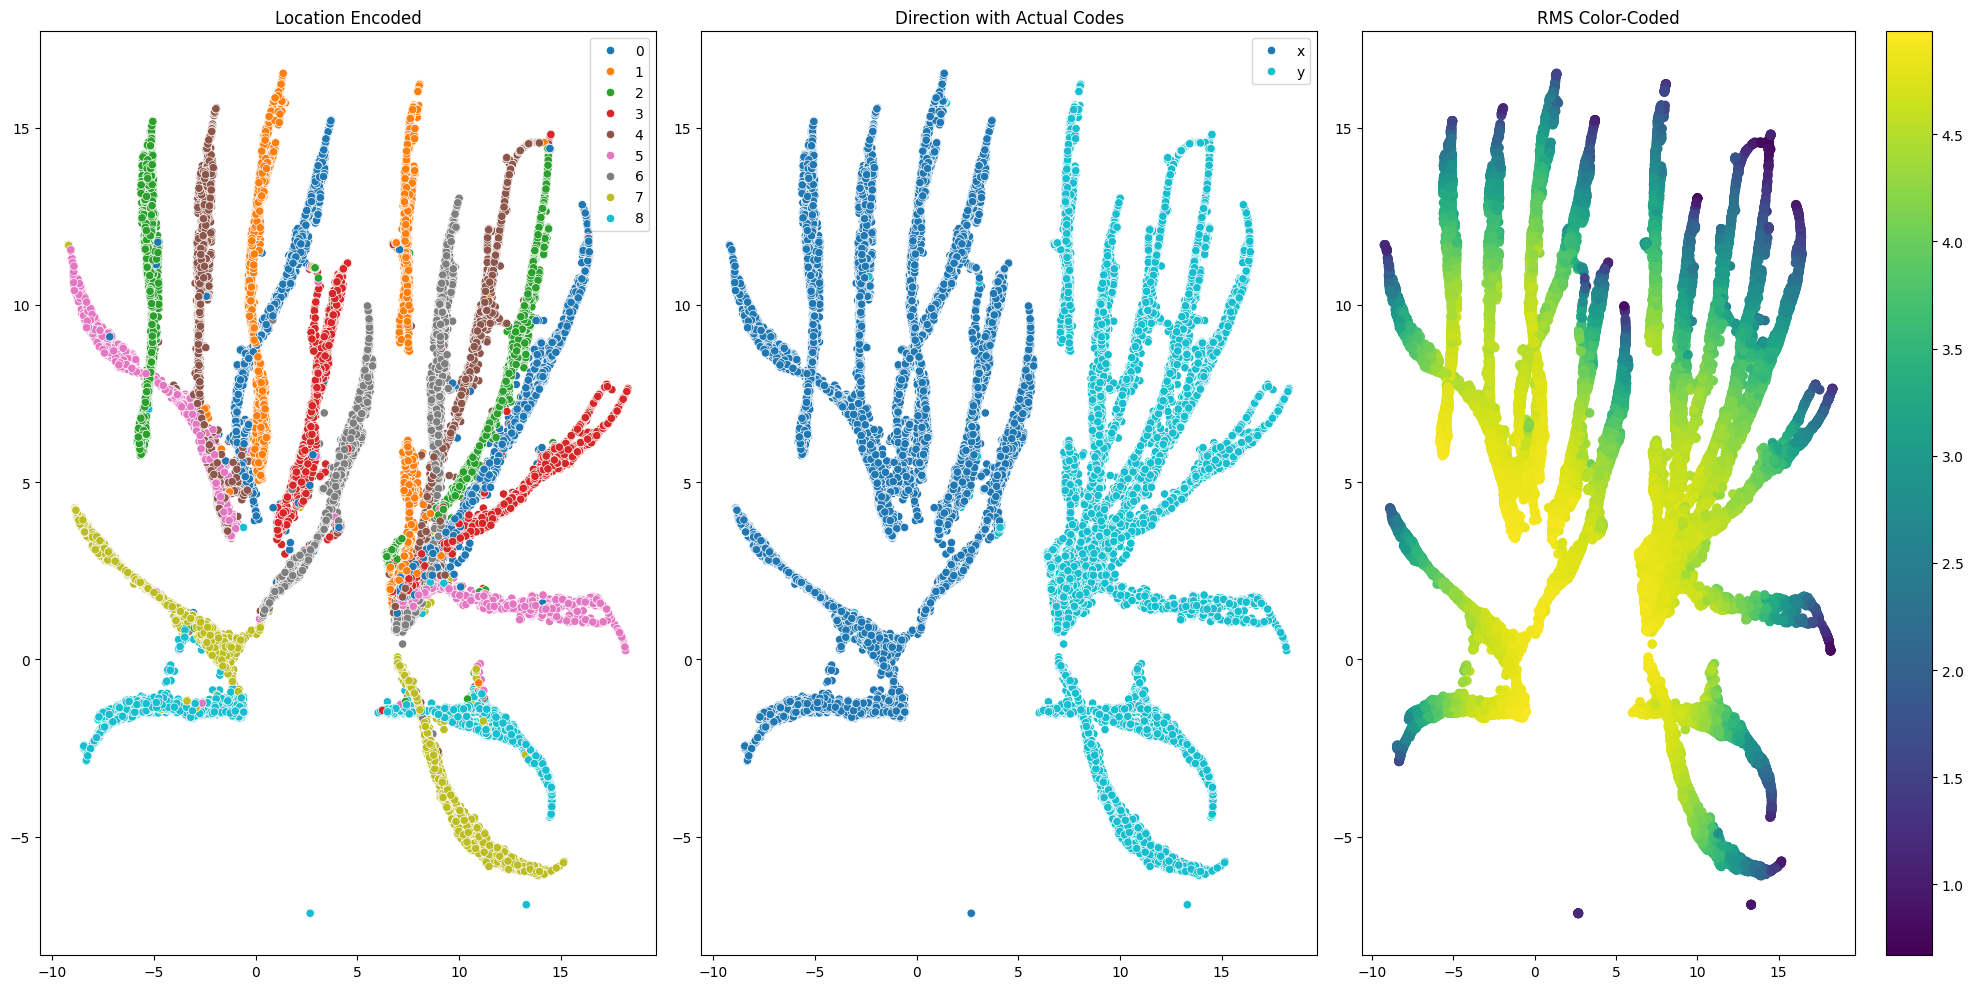

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.preprocessing import LabelEncoder
import numpy as np
import seaborn as sns

# Define unique categories for location and direction
unique_locations = np.unique(level_labels)
unique_directions = np.unique(direction_labels)

# Use a predefined colormap from matplotlib
location_cmap = plt.get_cmap('tab10', len(unique_locations))  # tab10 for location categories
direction_cmap = plt.get_cmap('tab10', len(unique_directions))  # Blues for direction categories

# Encode categorical variables into numeric values
location_encoded = LabelEncoder().fit_transform(level_labels)
direction_encoded = LabelEncoder().fit_transform(direction_labels)

fig, ax = plt.subplots(1, 3, figsize=(20, 10))

# Plot location-encoded scatter plot
sns.scatterplot(
    x=embedding_umap[:, 0],
    y=embedding_umap[:, 1],
    hue=location_encoded,
    palette=location_cmap.colors,
    ax=ax[0],
)

# Plot direction-encoded scatter plot, with actual labels in the legend
sns.scatterplot(
    x=embedding_umap[:, 0],
    y=embedding_umap[:, 1],
    hue=direction_labels,  # Use the actual direction values instead of encoded ones
    hue_order=np.unique(direction_labels),  # Ensure the order is the same as in the data
    palette=direction_cmap.colors,
    ax=ax[1],
)

# Scatterplot with rms and colorbar
scatter = ax[2].scatter(
    x=embedding_umap[:, 0],
    y=embedding_umap[:, 1],
    c=rms_values,
    cmap='viridis',  # Choose a colormap for rms values
)
cbar = fig.colorbar(scatter, ax=ax[2])  # Add colorbar to the figure for ax[2]

# Set titles for the subplots
ax[0].set_title('Location Encoded')
ax[1].set_title('Direction with Actual Codes')
ax[2].set_title('RMS Color-Coded')

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
detector = Detector(model.model) 
db_path = Path(settings.path.processed,'Welch(n_fft=16392, fs=1651, max_freq=825.5).db')
columns= ['psd','date','direction','level']
transform_func = [nn.Sequential(FromBuffer(),CutPSD(freq_axis=freq_axis,freq_range=(0,150))),nn.Identity(),nn.Identity(),nn.Identity()]
query_key = f'''
    SELECT id FROM data
    WHERE sensor = "accel"
    AND corrupted = 0
'''
data_loader = dm.PSDDataModule(db_path= db_path,columns=columns,transform_func=transform_func, query_key=query_key, batch_size=5000, return_dict=False, cached=False)
data_loader.setup()

df_res = pd.DataFrame(columns=['date', 'mse', 'direction', 'level'])

for batch in data_loader.all_dataloader():
    psds = batch[0]
    dates = batch[1]
    directions = batch[2]
    levels = batch[3]
    mse = detector(psds)
    df_temp = pd.DataFrame({'date': dates, 'mse': mse, 'direction': directions, 'level': levels})
    df_res = pd.concat([df_res, df_temp], axis=0)    

/tmp/ipykernel_3075643/1646381635.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_res = pd.concat([df_res, df_temp], axis=0)


In [ ]:
events = settings.state.to_dict()

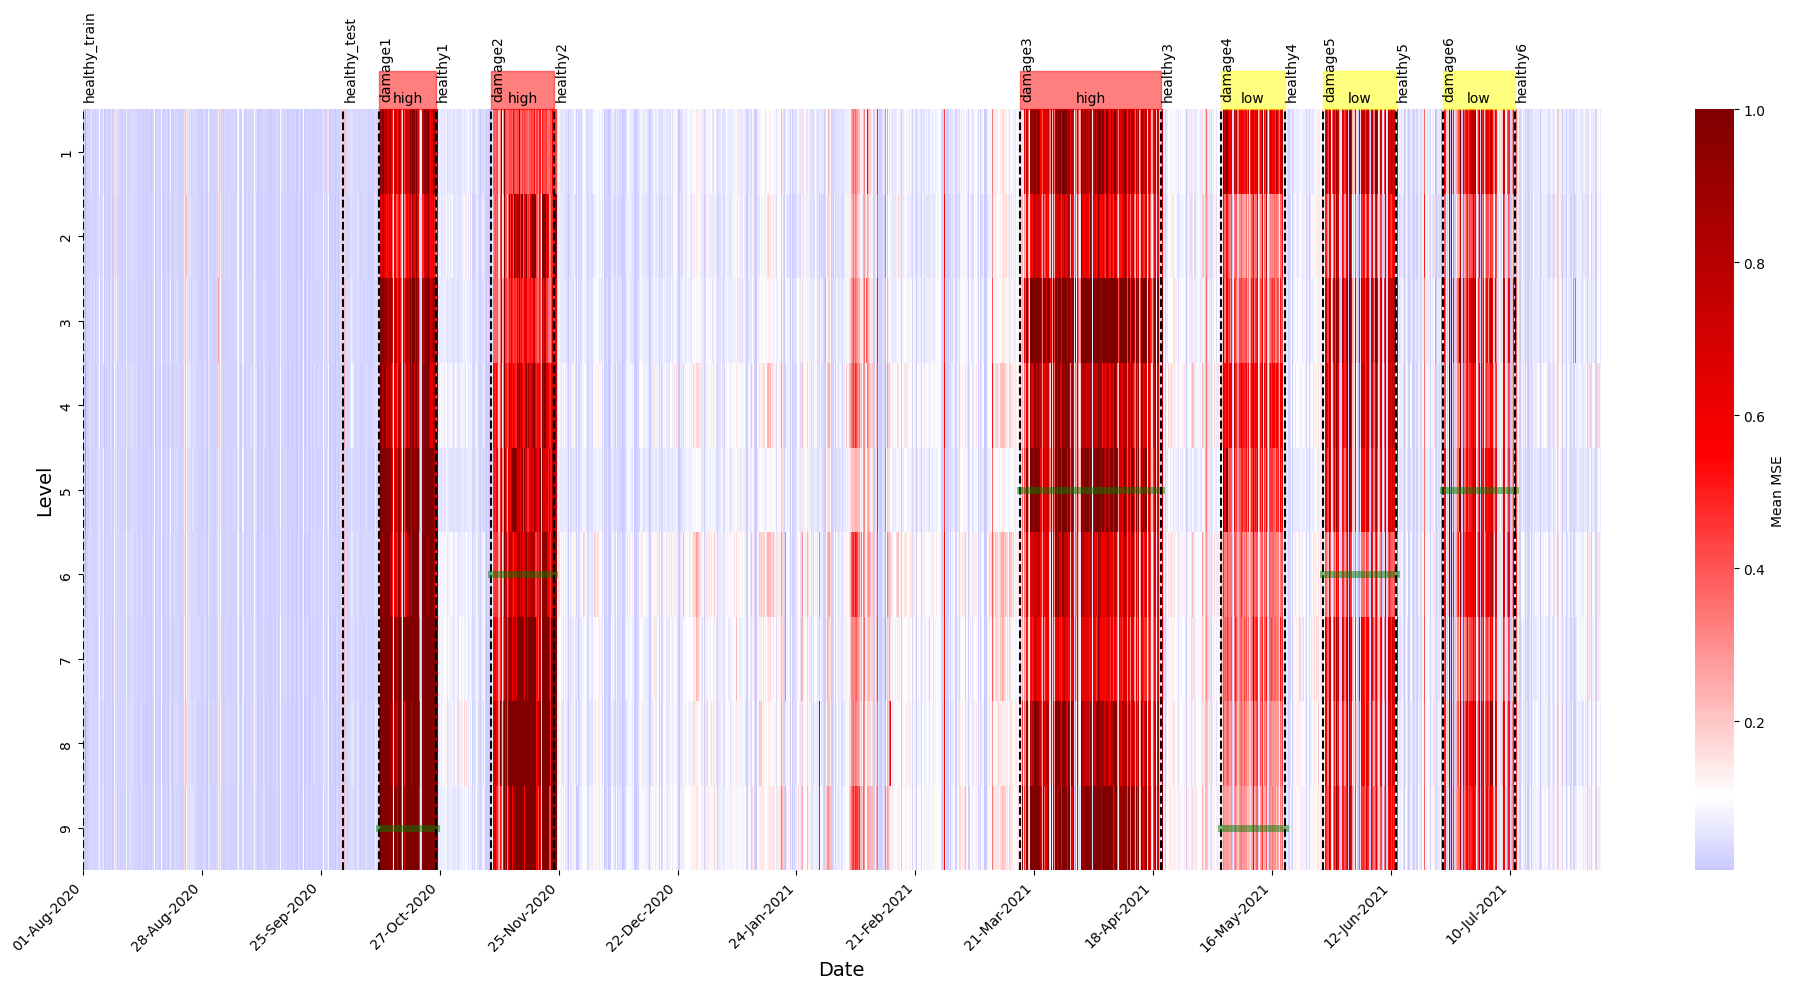

In [ ]:
from matplotlib.ticker import FuncFormatter

def create_date_formatter(column_dates):
    """Return a custom formatter function for datetime labels."""
    def custom_date_format(x, pos=None):
        if 0 <= int(x) < len(column_dates):
            return column_dates[int(x)].strftime('%d-%b-%Y')
        return ''  # Return empty string if out of range
    return FuncFormatter(custom_date_format)Votre position

# Apply the custom date formatter

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
from matplotlib.patches import Rectangle
import pandas as pd
import numpy as np
from functools import partial

# Filter the dataframe for 'y' direction and pivot the data for the heatmap
df_res['date'] = pd.to_datetime(df_res['date'])
df_res_y = df_res[df_res['direction'] == 'y']
df_pivot = df_res_y.pivot_table(index='level', columns=['date'], values='mse', aggfunc='mean')
# average the mse over 1hours rolling window with 1 hour step
fig, ax = plt.subplots(1, 1, figsize=(20, 10))

# Plot the heatmap with seaborn
df_pivot.columns = pd.to_datetime(df_pivot.columns)

sns.heatmap(
    df_pivot, 
    cmap='seismic',  # Set the color map to 'seismic' for highlighting extremes
    cbar_kws={'label': 'Mean MSE'},  # Add a color bar label
    ax=ax,
    center=0.1,
    vmax=1
)
# Set axis labels and title
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Level', fontsize=14)
ax.xaxis.set_major_formatter(create_date_formatter(df_pivot.columns))
ax.xaxis.set_major_locator(MaxNLocator(nbins=15))  # Set the maximum number of ticks

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

for event_i in events:
    start = pd.to_datetime(events[event_i]['start'])
    end = pd.to_datetime(events[event_i]['end'])
    idx_start = np.cumsum(df_pivot.columns < start)[-1]
    idx_end = np.cumsum(df_pivot.columns < end)[-1]
    
    # Draw vertical line and label for event
    ax.axvline(idx_start, color='black', linestyle='--', label=f'{event_i} start')
    ax.text(idx_start, -0.1, f'{event_i}', rotation=90, va='bottom', ha='left')
    
    # Draw horizontal line for the closest sensor level during the event
    level = events[event_i].get('closest_sensor', None)
    if level is not None:
        ax.axhline(level - 0.5, xmin=idx_start / len(df_pivot.columns), xmax=idx_end / len(df_pivot.columns), 
                   color='green', linestyle='-', lw=5, alpha=0.5)
    
    # Draw a box above the plot to indicate severity
    severity = events[event_i].get('severity', None)
    if severity is not None:
        color = 'red' if severity == 'high' else 'yellow'
        # Add rectangle patch above the plot to indicate severity
        box_height = 0.05  # Height of the box
        ax.add_patch(Rectangle(
            (idx_start, 1),  # Starting point of the box (above the plot)
            width=idx_end - idx_start,                # Width of the box
            height=box_height,                        # Height of the box
            color=color, 
            alpha=0.5,
            transform=ax.get_xaxis_transform(),       # Transform to place above the x-axis
            clip_on=False                             # Make sure the rectangle is not clipped
        ))
        ax.text((idx_start + idx_end) / 2, -0.1+ box_height, severity, ha='center', va='bottom', color='black')
# Tighten the layout
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
from hannover_pylon.utils.evaluation import label_dataframe_event, compute_TPR , auc_computation

In [ ]:
df_res['label']=label_dataframe_event(df_res['date'],events)

/home/owilab/Documents/YacineB/Code/hannover-pylon/hannover_pylon/evaluation/utils.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'healthy_train' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  labels.loc[mask] = event_name


In [ ]:
df_pivot = df_res.pivot_table(index='date',
                              columns=['direction', 'level'],
                              values='mse').reset_index()

# Flatten the MultiIndex columns
df_pivot.columns = [
    '_'.join([str(col) for col in column if col != 'date']) if column != 'date' else 'date'
    for column in df_pivot.columns
]


df_pivot.rename(columns={'': 'date'}, inplace=True)
df_pivot['label'] = label_dataframe_event(df_pivot['date'], events)

/home/owilab/Documents/YacineB/Code/hannover-pylon/hannover_pylon/evaluation/utils.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'healthy_train' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  labels.loc[mask] = event_name


In [ ]:
from sklearn.covariance import OAS
md = OAS()
md= md.fit(df_pivot.query('label == "healthy_train"').filter(regex='[a-z]_'))
df_pivot['mahalanobis'] = md.mahalanobis(df_pivot.filter(regex='[a-z]_'))


In [ ]:


threshold = df_pivot.query('label == "healthy_train"')['mahalanobis'].quantile(0.999)
df_pivot.groupby(['label']).apply(lambda x: compute_TPR(x['mahalanobis'].values, threshold))

/tmp/ipykernel_3075643/3846486056.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_pivot.groupby(['label']).apply(lambda x: compute_TPR(x['mahalanobis'].values, threshold))


label
damage1          0.963931
damage2          0.907728
damage3          0.876267
damage4          0.786741
damage5          0.667623
damage6          0.615669
healthy1         0.046537
healthy2         0.048203
healthy3         0.068024
healthy4         0.009266
healthy5         0.039415
healthy6         0.035094
healthy_test     0.000833
healthy_train    0.001028
dtype: float64

In [ ]:
min_md, max_md = df_pivot.query('label == "healthy_train"')['mahalanobis'].quantile(0.001), df_pivot.query('label == "healthy_train"')['mahalanobis'].quantile(0.999)
df_pivot['mahalanobis'] = (df_pivot['mahalanobis'] - min_md) / (max_md - min_md)
threshold = df_pivot.query('label == "healthy_train"')['mahalanobis'].quantile(0.999)
df_pivot['group_label'] = df_pivot['label'].apply(lambda x: 'healthy' if x.startswith('healthy') else x)
score = df_pivot.groupby(['label']).apply(lambda x: np.median(x['mahalanobis'].values)) 
score = score / score['healthy_train']
order_of_states = list(settings.state.to_dict().keys())
# reorder the score according to the order of the states
score = score.loc[order_of_states]
score

/tmp/ipykernel_3075643/2519269049.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  score = df_pivot.groupby(['label']).apply(lambda x: np.median(x['mahalanobis'].values))


label
healthy_train         1.000000
healthy_test          1.710787
damage1          189151.998211
healthy1             14.065725
damage2           41021.842856
healthy2             40.863144
damage3           10169.006993
healthy3             38.425176
damage4             847.543248
healthy4             40.790436
damage5            1250.613132
healthy5             17.279885
damage6             725.416699
healthy6             20.708342
dtype: float64

In [ ]:
order_of_states = list(settings.state.to_dict().keys())
# reorder the score according to the order of the states
score = score.loc[order_of_states]
# compute the ratio between consecutive states
ratio = score.pct_change()
ratio

label
healthy_train              NaN
healthy_test          0.710787
damage1          110563.291652
healthy1             -0.999926
damage2            2915.439889
healthy2             -0.999004
damage3             247.855227
healthy3             -0.996221
damage4              21.056977
healthy4             -0.951872
damage5              29.659470
healthy5             -0.986183
damage6              40.980414
healthy6             -0.971453
dtype: float64

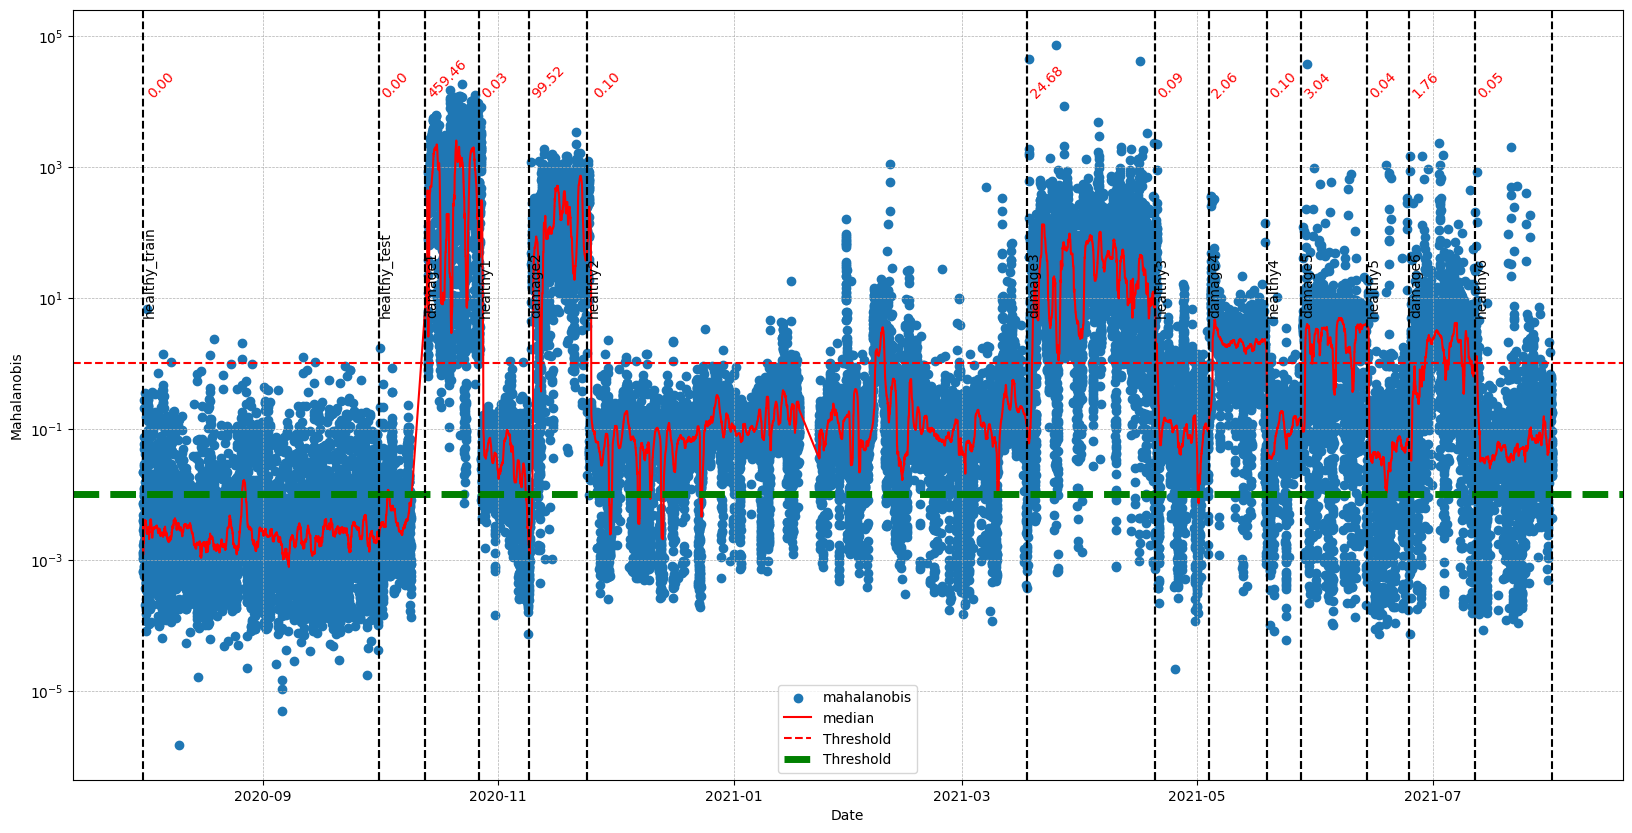

In [ ]:
fig , ax = plt.subplots(1,1,figsize=(20,10))
df_pivot['date'] = pd.to_datetime(df_pivot['date'])
df_pivot.index = df_pivot['date']
ax.scatter(df_pivot['date'],df_pivot['mahalanobis'],label='mahalanobis')
# plot a moving average of the mahalanobis score 
ax.plot(df_pivot['date'],df_pivot['mahalanobis'].rolling('1D').median(),label='median',color='red')
ax.axhline(threshold, color='red', linestyle='--', label='Threshold')
ax.axhline(1e-2, color='green', linestyle='--', label='Threshold',lw=5)

ax.set_xlabel('Date')
ax.set_ylabel('Mahalanobis')
ax.legend()
ax.grid(which='both', linestyle='--', linewidth=0.5)
ax.set_yscale('log')
for event_i in events:
    start = pd.to_datetime(events[event_i]['start'])
    end = pd.to_datetime(events[event_i]['end'])
    ax.axvline(start, color='black', linestyle='--', label=f'{event_i} start')
    ax.axvline(end, color='black', linestyle='--', label=f'{event_i} end')
    ax.text(start, 5, f'{event_i}', rotation=90, va='bottom', ha='left')
    # compute the mean of the mahalanobis score during the event
    mask = (df_pivot['date'] >= start) & (df_pivot['date'] <= end)
    mid_point = (end - start) / 100 + start 
    mean = df_pivot.loc[mask, 'mahalanobis'].median()
    ax.text(mid_point, 10000, f'{mean:.2f}', rotation=45, va='bottom', ha='left', color='red') 

In [ ]:
df_row = df_res.query("direction == 'y' and level == 1")
reference = df_row.query("label == 'healthy_test' ")
reference_data = reference['mse'].values
partial_auc = partial(auc_computation,reference_data)
df_row.groupby(['label']).apply(lambda x: partial_auc(x['mse'].values))

/tmp/ipykernel_3075643/1096168990.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_row.groupby(['label']).apply(lambda x: partial_auc(x['mse'].values))


label
damage1          0.999397
damage2          0.979153
damage3          0.984391
damage4          0.984731
damage5          0.933405
damage6          0.935971
healthy1         0.822380
healthy2         0.867438
healthy3         0.901312
healthy4         0.908642
healthy5         0.781381
healthy6         0.852794
healthy_test     0.500000
healthy_train    0.346714
dtype: float64

In [ ]:
import re

pattern_healthy = re.compile(r'healthy')
pattern_dmg = re.compile(r'damage')

# Extract states that match the pattern
healthy_states = [state for state in events.keys() if pattern_healthy.search(state) and 'train' not in state] 
# remove train states
damage_state = [state for state in events.keys() if pattern_dmg.search(state)]

In [ ]:
# compute the AUC for each state and the healthy state 
df_row = df_res.query("direction == 'y' and level == 3")
# query all the healthy states
reference = df_row.query("label in @healthy_states")
reference_data = reference['mse'].values
partial_auc = partial(auc_computation,reference_data)
df_row.groupby(['label']).apply(lambda x: partial_auc(x['mse'].values))[:6]

/tmp/ipykernel_3075643/1330796986.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_row.groupby(['label']).apply(lambda x: partial_auc(x['mse'].values))[:6]


label
damage1    0.980824
damage2    0.941476
damage3    0.949584
damage4    0.921619
damage5    0.833966
damage6    0.817450
dtype: float64